# 라이브러리

In [1]:
import pandas as pd
import numpy as np

import re
import seaborn as sns
sns.set(style = 'white')
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.ticker as mtick # For specifying the axes tick format 
# import plotly
# import plotly.graph_objs as go
# import plotly.express as px
# import plotly.graph_objects as go
# from plotly import offline
# from plotly.subplots import make_subplots
palette = sns.color_palette('Set3')

import warnings
warnings.filterwarnings('ignore')

# Label Encoding
from sklearn.preprocessing import LabelEncoder

# modeling
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import StackingClassifier, BaggingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

import pandas_profiling
import pandas_profiling.profile_report
    # supposed to be deprecated
    # import ydata_profiling
    # from ydata_profiling import ProfileReport

import shap
import eli5
from eli5.sklearn import PermutationImportance
from matplotlib.pyplot import figure

from warnings import warn
import warnings
warnings.filterwarnings('ignore')
import warnings
warnings.filterwarnings(action='ignore')

    # Label Encoding
from sklearn.preprocessing import LabelEncoder

    # modeling
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn import model_selection
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier, VotingClassifier, StackingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, KFold
from lightgbm import LGBMClassifier

from sklearn import metrics
from sklearn.metrics import classification_report, precision_recall_curve
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import make_scorer, recall_score, log_loss
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import RocCurveDisplay



2023-07-03 18:19:29.239538: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 1. 데이터 확인

In [2]:
df = pd.read_csv('./telecom_customer_churn.csv', encoding='euc-kr')

#### 데이터 파악

In [3]:
# df.profile_report()
df.head()

,Customer ID,Gender,Age,Married,Number of Dependents,City,Zip Code,Latitude,Longitude,Number of Referrals,...,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Customer Status,Churn Category,Churn Reason
0,0002-ORFBO,Female,37,Yes,0,Frazier Park,93225,34.827662,-118.999073,2,...,Credit Card,65.6,593.30,0.00,0,381.51,974.81,Stayed,NaN,NaN
1,0003-MKNFE,Male,46,No,0,Glendale,91206,34.162515,-118.203869,0,...,Credit Card,-4.0,542.40,38.33,10,96.21,610.28,Stayed,NaN,NaN
2,0004-TLHLJ,Male,50,No,0,Costa Mesa,92627,33.645672,-117.922613,0,...,Bank Withdrawal,73.9,280.85,0.00,0,134.60,415.45,Churned,Competitor,Competitor had better devices
3,0011-IGKFF,Male,78,Yes,0,Martinez,94553,38.014457,-122.115432,1,...,Bank Withdrawal,98.0,1237.85,0.00,0,361.66,1599.51,Churned,Dissatisfaction,Product dissatisfaction
4,0013-EXCHZ,Female,75,Yes,0,Camarillo,93010,34.227846,-119.079903,3,...,Credit Card,83.9,267.40,0.00,0,22.14,289.54,Churned,Dissatisfaction,Network reliability


In [4]:
# rename cols for our convenience
df.rename(lambda x: x.lower().strip().replace(' ', '_'), axis='columns', inplace=True)

# 2. 데이터 전처리

## Columns Prep

In [5]:
# drop 'Joined' customers to avoid prediction bias
df = df[df["customer_status"] != "Joined"]

# create a new col
df['churn'] = np.where(df['customer_status'] == 'Churned', 'Yes', 'No')
df = df.drop(['customer_status'], axis = 1)

# exclude customers who spend under 0 dollar for monthly charge
df = df[df['monthly_charge'] > 0]

In [6]:
# binning age
def binning(x):
    if x >= 19 and x < 29:
        return 20
    elif x >= 29 and x < 39:
        return 30
    elif x >= 39 and x < 49:
        return 40
    elif x >=49 and x < 59:
        return 50
    elif x >= 59 and x < 69:
        return 60
    return 70

df['age_range'] = df['age'].apply(binning)
df['age_range'].value_counts().sort_index()

20    1175
30    1127
40    1228
50    1157
60     973
70     815
Name: age_range, dtype: int64

In [7]:
# binning tenure based on contract period - to explore whether contract period (month to month, 1 year, 2 years) affect tenure later visualising
df['tenure_in_years'] = 0

def binning_tenure(x):
    if x < 12:
        return 0
    elif x >= 12 and x < 24:
        return 1
    elif x >= 24 and x < 36:
        return 2
    elif x >= 36 and x < 60:
        return 3
    return 4

df['tenure_in_years'] = df['tenure_in_months'].apply(binning_tenure)
df['tenure_in_years'].value_counts().sort_index()

0    1580
1    1024
2     864
3    1550
4    1457
Name: tenure_in_years, dtype: int64

## 2-1. Duplicated value

In [8]:
print(df.duplicated('customer_id', keep=False).sum())
    # Check for the absence of Duplicate Values on 'customer_id'

0


## 2-2. Missing value

In [9]:
# df.isnull().sum()
df.isnull().sum().to_frame('nan_count')

,nan_count
customer_id,0
gender,0
age,0
married,0
number_of_dependents,0
city,0
zip_code,0
latitude,0
longitude,0
number_of_referrals,0


#### Nulls of features that are related to 'Phone Service'

In [10]:
df['avg_monthly_long_distance_charges'] = df['avg_monthly_long_distance_charges'].fillna(df['avg_monthly_long_distance_charges'].mean())
df.multiple_lines = df.multiple_lines.fillna('No Phone Service')

#### Nulls of features that are related to 'Internet Service'

In [11]:
no_internet_service = ['internet_type', 'online_security', 'online_backup', 'device_protection_plan','premium_tech_support',
                       'streaming_tv', 'streaming_movies', 'streaming_music', 'unlimited_data']
df[no_internet_service] = df[no_internet_service].fillna('No Internet Service')
df['avg_monthly_gb_download'] = df['avg_monthly_gb_download'].fillna(df['avg_monthly_gb_download'].mean())

#### Nulls of object columns to 'None'

# 3. 문제 정의

### Churn Distributions

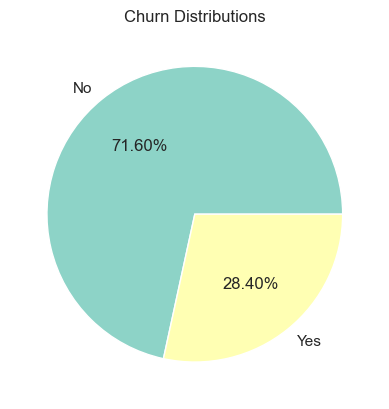

In [12]:
type_ = ["No", "Yes"]
values = df['churn'].value_counts().values.tolist()
plt.pie(values, labels=type_, autopct = '%.02f%%', colors = palette)
# df['churn'].value_counts().plot(kind='pie', autopct ='%1.1f%%', colors = palette)
plt.title('Churn Distributions')
plt.show()

In [13]:
df['total_revenue'].sum()

20990372.430000003

In [14]:
df.groupby(['churn'])['total_revenue'].sum()

churn
No     17337004.13
Yes     3653368.30
Name: total_revenue, dtype: float64

In [15]:
df.groupby(['churn']).size()

churn
No     4636
Yes    1839
dtype: int64

- Percentage of churned customers = 28.40%
- Total customers' contributions = approx. \$ 20,990,372
- Churned customers' contributions = approx. \$ 3,653,368 (about 17%)
- 분석 이외 자료: 신규 가입자의 경우는 454명으로 예측 편향성을 피하기 위해 삭제했다.
- 이 분석의 목적은 기존 고객들에 포커스를 맞추어 이탈 위험성이 있는 고객들을 꾸준히 보유할 수 있는 인사이트를 제공하기 위함이다. 


In [16]:
df.groupby('churn')['monthly_charge'].sum()

churn
No     291879.60
Yes    137231.65
Name: monthly_charge, dtype: float64

In [17]:
df.groupby('churn')['monthly_charge'].describe()

,count,mean,std,min,25%,50%,75%,max
churn,,,,,,,,
No,4636.0,62.959362,31.168714,18.25,25.450,66.40,89.75,118.75
Yes,1839.0,74.622974,24.604751,18.85,56.925,79.65,94.25,118.35


- 약 30퍼센트에 해당하는 월별 기대 이익이 줄어들었다.
- 이탈 고객이 유지 고객 보다 평균 월 요금을 더 많이 내고 있는 것을 확인했다.
- 월 요금이 높을수록 이탈할 가능성이 높을 수 있다.

In [18]:
df.groupby('gender')['churn'].describe()
# df.churn[df.churn == 'No'].groupby(by = df.gender).count()

,count,unique,top,freq
gender,,,,
Female,3229,2,No,2307
Male,3246,2,No,2329


- Gender doesn't have to with churning

### 주소와의 데이터 (zip_code, latitude, longitude ...)

In [19]:
df.groupby('zip_code')['total_long_distance_charges'].describe()

,count,mean,std,min,25%,50%,75%,max
zip_code,,,,,,,,
90001,3.0,437.323333,721.671259,0.00,20.8400,41.680,655.9850,1270.29
90002,3.0,991.833333,686.604221,581.06,595.5100,609.960,1197.2200,1784.48
90003,3.0,349.900000,534.822333,20.94,41.3450,61.750,514.3800,967.01
90004,5.0,325.978000,448.154537,0.00,3.0900,133.380,429.1200,1064.30
90005,4.0,449.367500,445.533807,18.24,104.3325,416.615,761.6500,946.00
...,...,...,...,...,...,...,...,...
96143,4.0,555.537500,547.571228,87.24,99.2100,479.055,935.3825,1176.80
96145,3.0,1199.090000,962.750386,309.96,687.8550,1065.750,1643.6550,2221.56
96146,2.0,1015.500000,110.732922,937.20,976.3500,1015.500,1054.6500,1093.80


<AxesSubplot: xlabel='longitude', ylabel='latitude'>

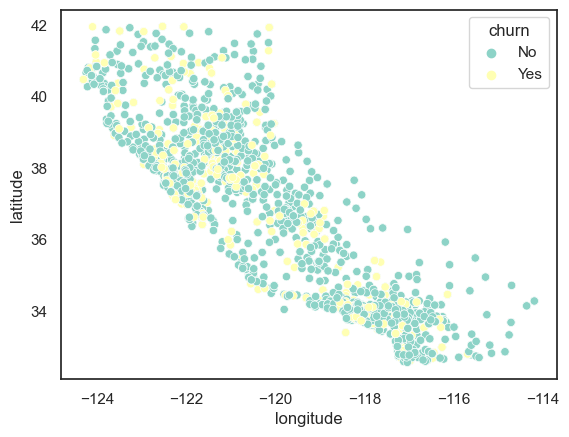

In [20]:
sns.scatterplot(data = df, x='longitude', y='latitude', hue='churn', palette = 'Set3')

- 지역별로 보았을 때 한 곳에 이탈 고객이 몰려있거나 하는 특징이 없다.
- 이후 분석에 필요 없으므로 컬럼을 삭제한다.

In [21]:
df = df.drop(['zip_code', 'latitude', 'longitude', 'city'], axis = 1)

### Churning Reasons

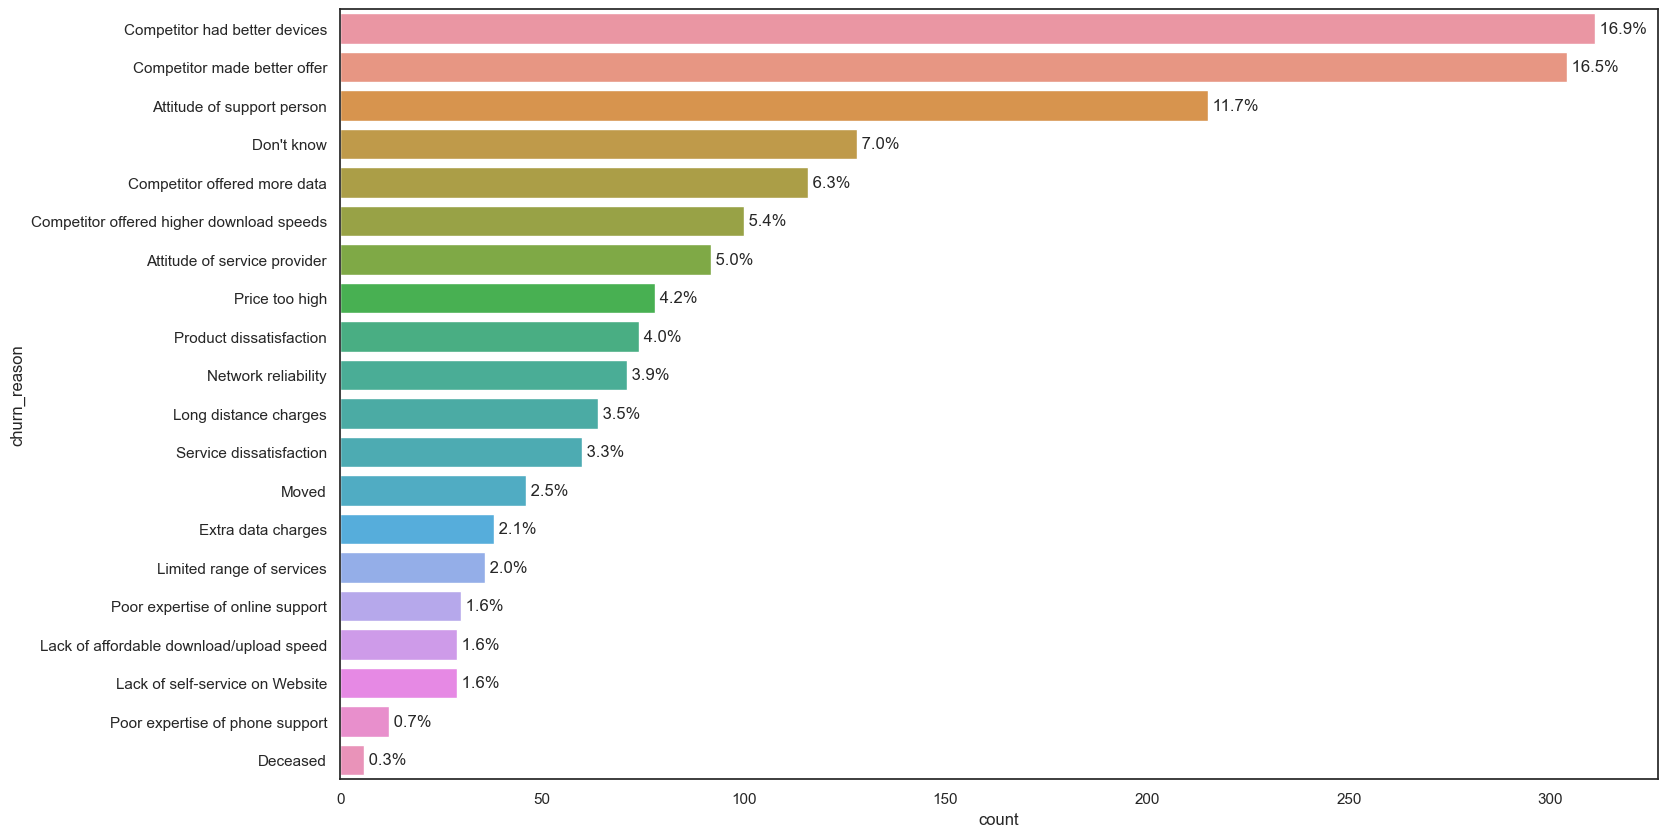

In [22]:
# sns.countplot(data = df, y = 'churn_reason', order = df['churn_reason'].value_counts().index)
# order 사용하여 내림차순으로 정렬


import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(17,10))
churn_reason = df['churn_reason'].dropna()
sns.countplot(data=df, y=churn_reason, ax=ax, order=df['churn_reason'].value_counts().index)
total = len(churn_reason)
for p in ax.patches: # ax.patches : 그래프 위에 비율 쓰고 싶을 때 사용하는 메소드
    percentage = '{:.1f}%'.format(100 * p.get_width()/total)
    x = p.get_x() + p.get_width()
    y = p.get_y() + p.get_height() / 2
    ax.annotate(' '+percentage, (x,y), ha='left', va='center', fontsize=12)
plt.show()
# good

- 타 경쟁사가 제공하는 'better devices' & 'better offers'가 가장 유력한 이탈 이유.
- 세 번째로는 'Attitude of support person'으로, 기기와 좋은 패키지를 제공하는 것 이외에 CS에 관하여 전반적인 교육이 필요함을 추측할 수 있다.
- 이외로 가격에 대한 이탈 이유는 없는 것으로 보아 금액적인 부분은 고객들에게 문제가 되지 않을 수 있음을 추측할 수 있다.

In [23]:
# drop no need cols
df=df.drop(columns=['customer_id','churn_category','churn_reason'], axis = 1)

In [24]:
df.columns

Index(['gender', 'age', 'married', 'number_of_dependents',
       'number_of_referrals', 'tenure_in_months', 'offer', 'phone_service',
       'avg_monthly_long_distance_charges', 'multiple_lines',
       'internet_service', 'internet_type', 'avg_monthly_gb_download',
       'online_security', 'online_backup', 'device_protection_plan',
       'premium_tech_support', 'streaming_tv', 'streaming_movies',
       'streaming_music', 'unlimited_data', 'contract', 'paperless_billing',
       'payment_method', 'monthly_charge', 'total_charges', 'total_refunds',
       'total_extra_data_charges', 'total_long_distance_charges',
       'total_revenue', 'churn', 'age_range', 'tenure_in_years'],
      dtype='object')

# 4. 데이터 시각화 / EDA

### 전체 컬럼 분포

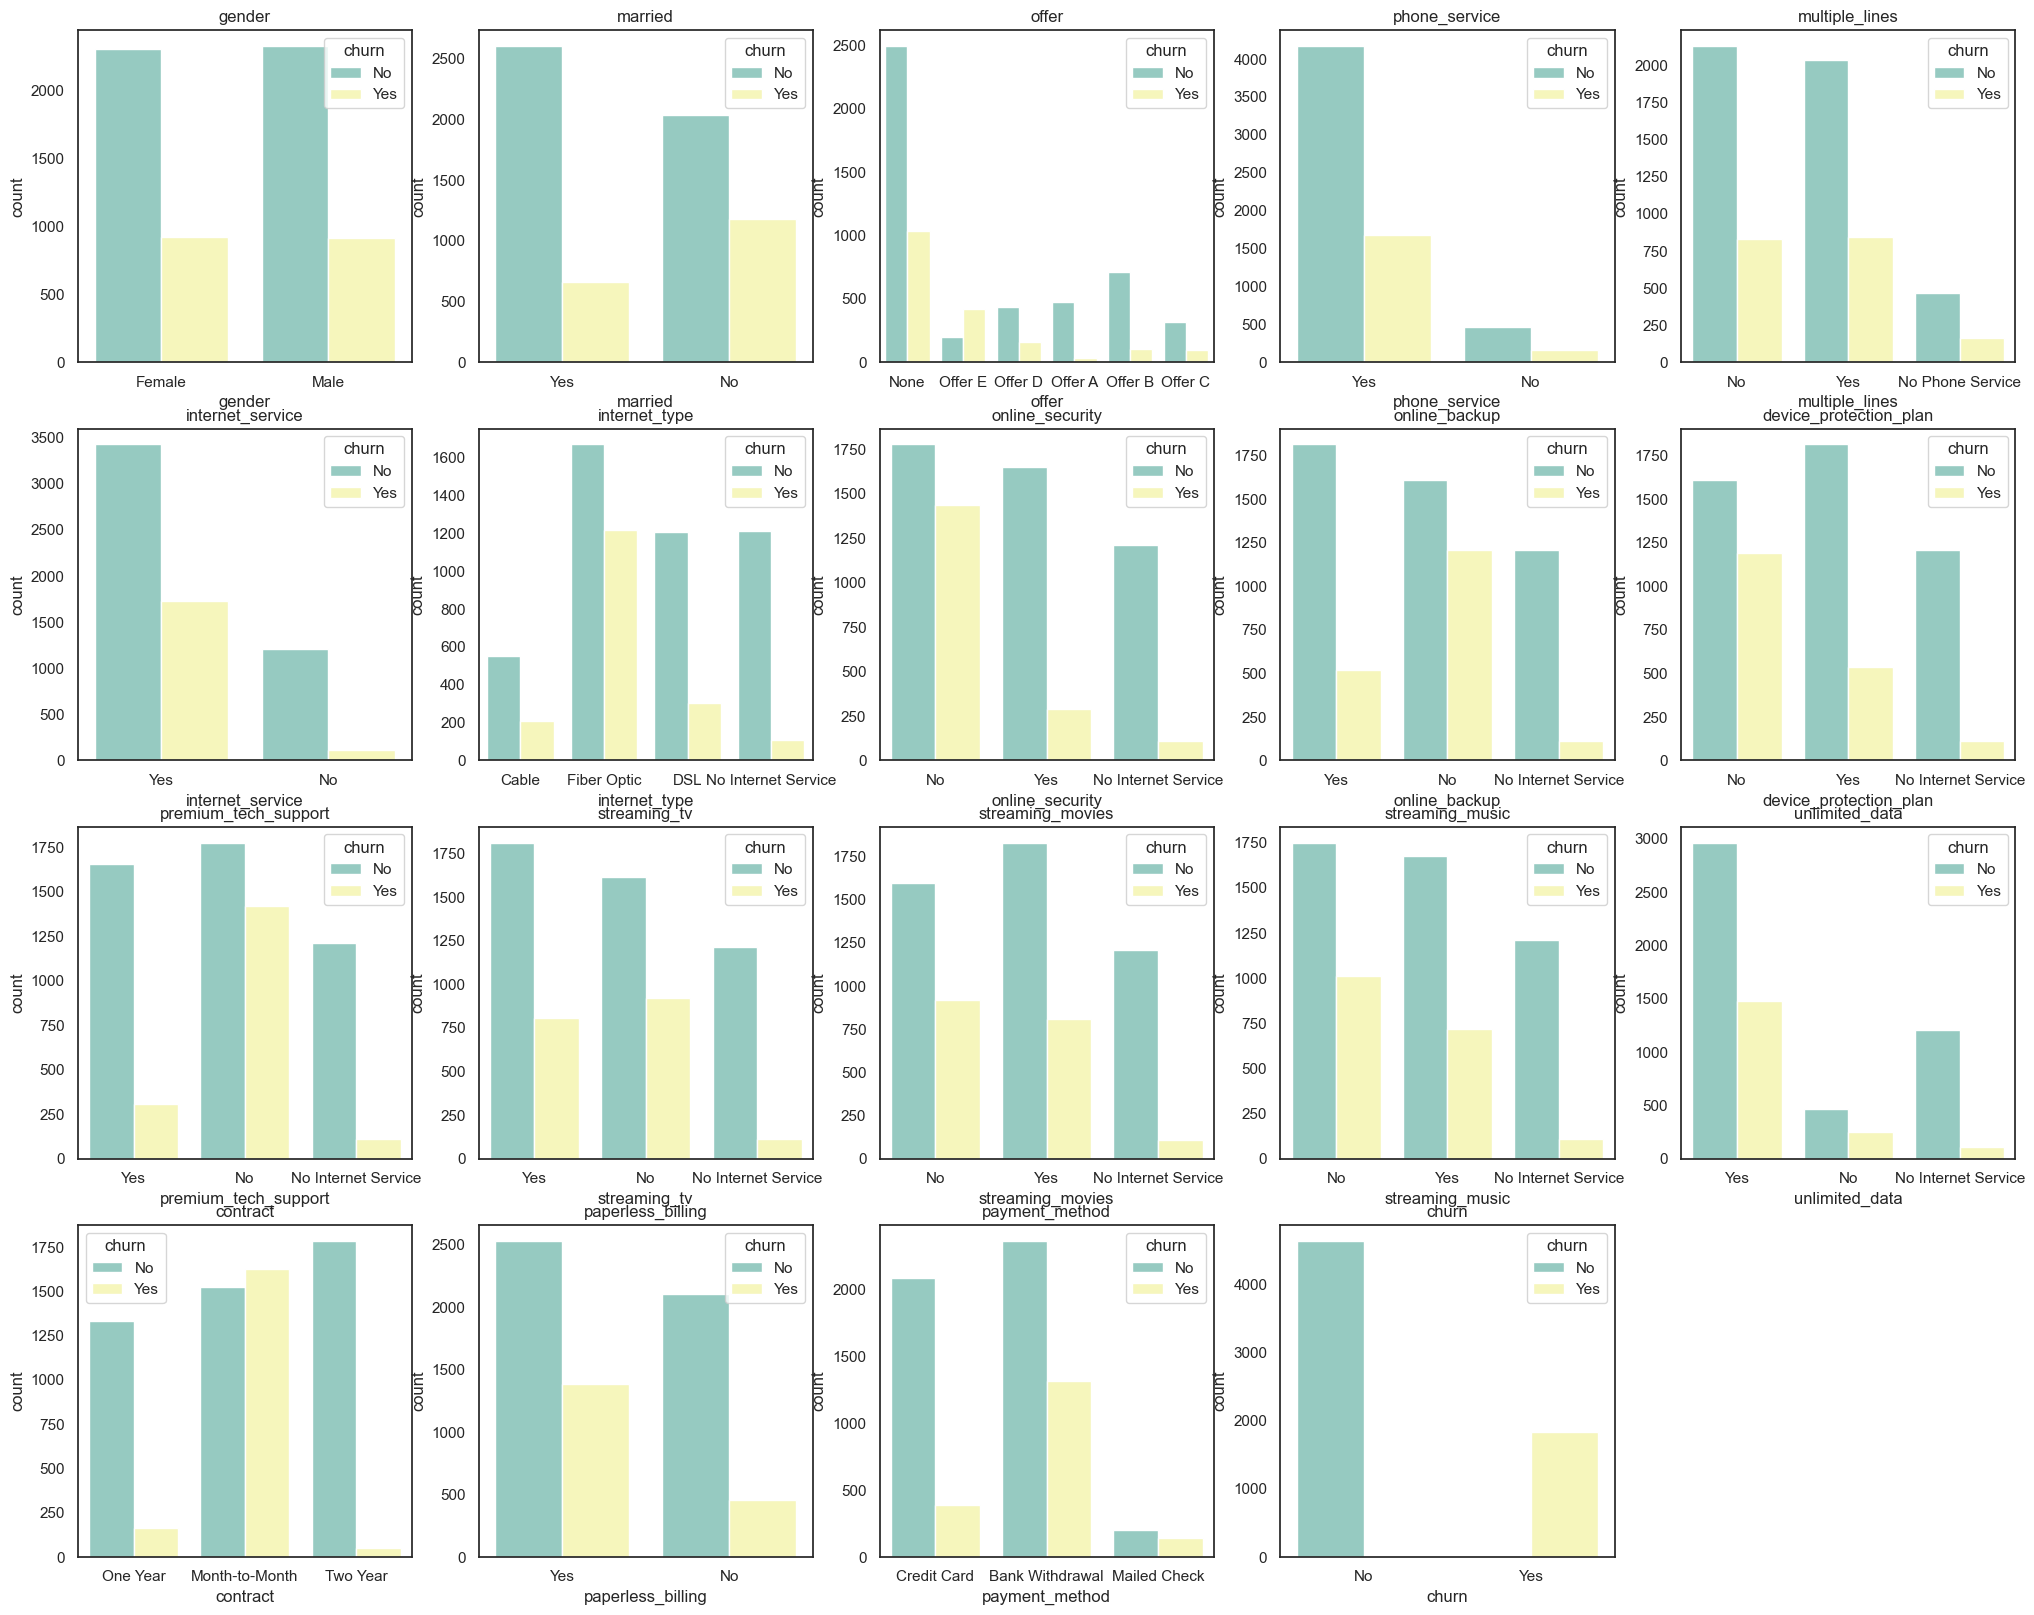

In [25]:
object_col = [col for col in df.columns if df[col].dtype == 'object']

plt.figure(figsize = (25, 25))
for i, col in enumerate(object_col):
    ax = plt.subplot(5, 5, i + 1)
    sns.countplot(x = str(col), hue = 'churn', data = df, palette = palette)
    ax.set_title(str(col))

- **offer**: 대부분의 고객은 마케팅 제안을 수락하지 않는다.
    - 낮은 마케팅율을 개선이 필요하다.
    - 제안 E를 구독한 고객들 사이에서 높은 이탈율을 확인했다. 회사는 제안 E의 pain points를 확인해서 개선해야 한다. 추가적으로, 관련이 있는 다른 마케팅 오퍼에 대해서도 꼼꼼한 점검이 필요하다. 
<br><br>
- **internet service**: 인터넷 서비스에 가입하면 이탈율이 높아진다.
    - 결합해서 쓰는 경우 이탈율 높아짐 34.5%
    - 인터넷 서비스 유저 이탈율 26.4%
    - 폰서비스 유저 이탈율 8.4%
    - 인터넷 서비스에서의 보완이 필요할 수 있다.
<br><br>
- **internet type**: Fiber > DSL > Cable
    - 다양한 인터넷 연결 유형 중 Fiber Optic이 가장 널리 사용된다. Cable 및 DSL에 비해 가격이 비싸더라도 다운로드 및 업로드 속도가 가장 빠르기 때문입니다.
    - 인터넷 요금이 비싼 것에 비해 통신사쪽 메리트가 없다고 생각할 수 있다.
        - 통신사쪽 메리트가 필요.
<br><br>
- **online security, online backup, device protection plan**: 인터넷 부가서비스.
    - 이탈 고객은 이 기능을 구매(선택)할 가능성이 거의 없다.
    - 인터넷 부가서비스에 대한 이점이 있을 수 있다.
    - 마케팅을 제안할 것이라면 위와 괕은 인터넷 부가서비스에 대한 마케팅이 좋은 효과를 가지고 올 수 있다.
        - 이걸 확인하려면 이 서비스 가입한 사람들의 이탈율을 봐야한다.
<br><br>
- **premium tech support**: 많은 이탈 고객이 premium tech support를 받지 않았다.
    - 기술적 문제가 이탈 결정에 영향을 미칠 수도 있다는 것을 알 수 있다.
    - 이 부가서비스에 대한 가입자의 이탈율도 확인해볼 수 있다. 
<br><br>
- **unlimited data**: 많은 고객에게 무제한 데이터가 인기가 있습니다.
    - 이와 관련한 이벤트?
<br><br>
- **contract**: 월 단위로 지불하는 사용자는 이탈할 가능성이 높습니다.
    - 대부분의 충성 고객은 1, 2년 계약입니다.
<br><br>
- **streaming tv, movies, music**: 충성고객과 이탈고객의 큰 차이가 없이 균등하다.
    - 고객 이탈 여부에 영향을 미치지 않는다.
<br><br>
- **multiple lines**: 충성고객과 이탈 고객이 균등하게 분배되어 있다. 고객 이탈 여부에 영향을 미치지 않을 것이라고 생각할 수 있습니다.
<br><br>


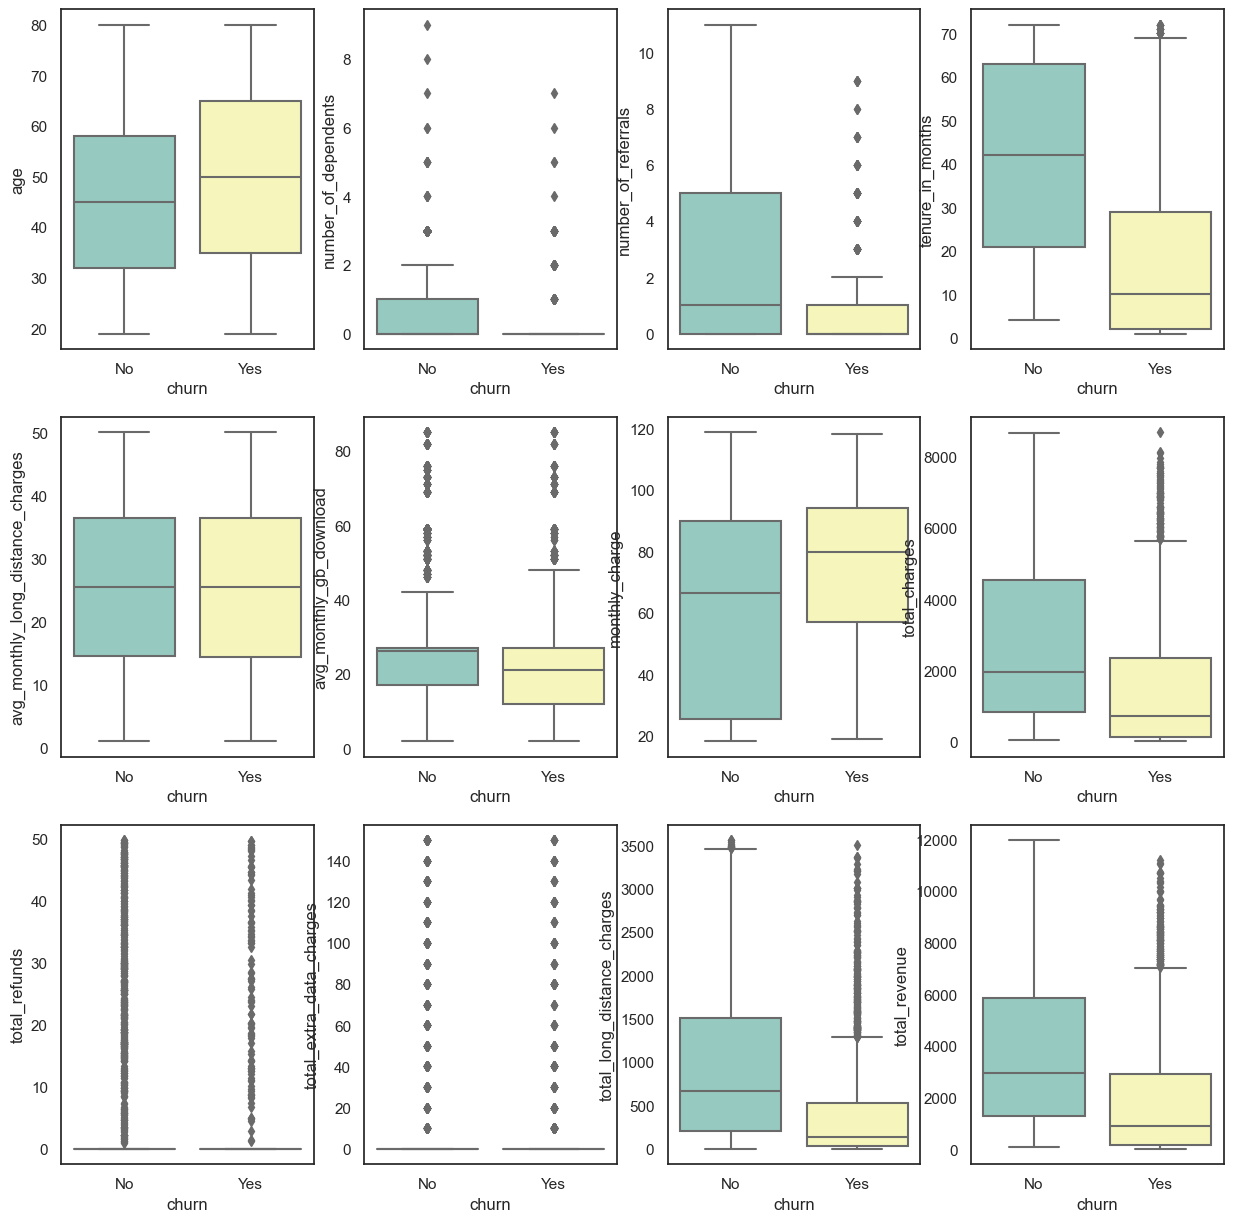

In [26]:
number_col = ['age', 'number_of_dependents', 'number_of_referrals', 'tenure_in_months', 'avg_monthly_long_distance_charges',
              'avg_monthly_gb_download', 'monthly_charge', 'total_charges', 'total_refunds', 'total_extra_data_charges',
              'total_long_distance_charges', 'total_revenue']
fig, ax = plt.subplots(3,4, figsize = (15,15))
for i, subplot in zip(number_col, ax.flatten()):
    sns.boxplot(x = 'churn', y = i , data = df, ax = subplot, palette = 'Set3')

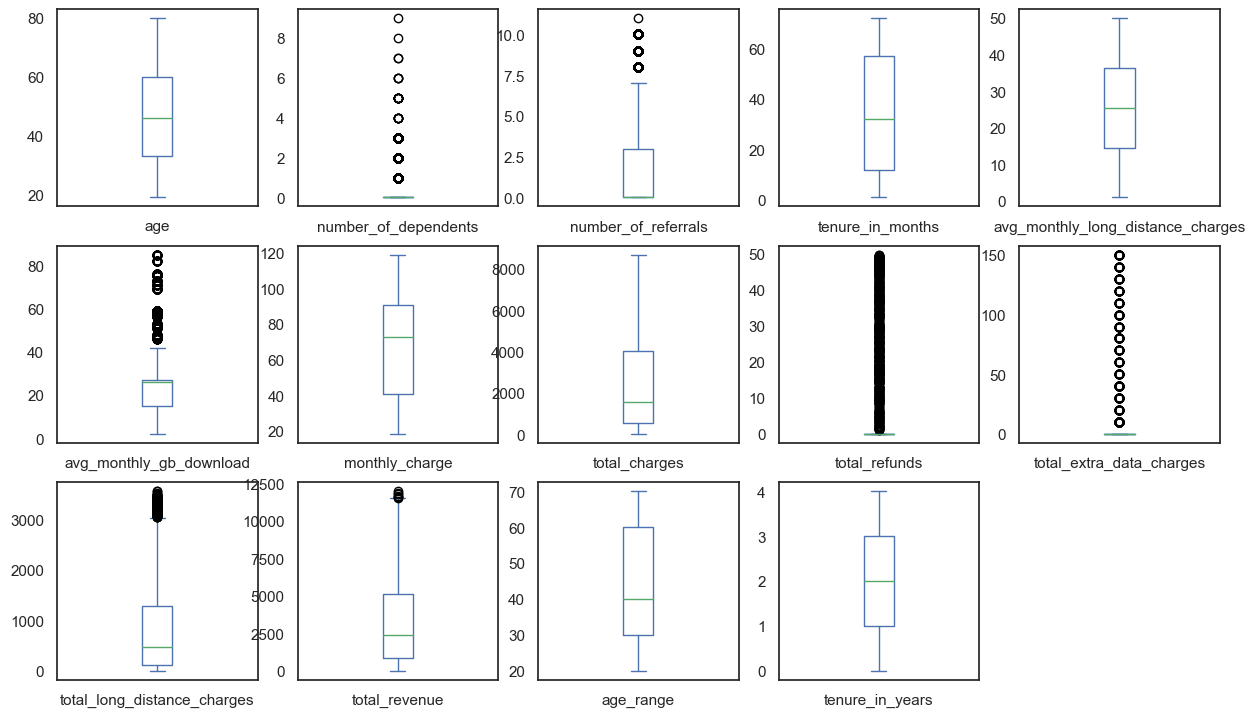

In [27]:
df.plot(kind='box', subplots=True, layout=(7, 5), figsize=(15, 21))
plt.show()
# 수치형 컬럼에 대한 이상치 확인

- **number of dependents**: 대부분의 고객은 부양가족이 없다.
- **monthly charge**: 이탈 고객의 월간 요금 중앙값이 충성고객의 월간 요금 중앙값보다 높다는 것을 알 수 있다. 요금이 너무 높으면 고객이 이탈할 가능성이 더 높다고 생각할 수 있다.
    - 높은 요금을 사용하는 메리트가 없다는 의미가 될 수도 있다.


### 인터넷 가입 여부와 인터넷 부가서비스의 관계

In [28]:
internet_df = df.copy()
internet_df = internet_df.loc[(internet_df['internet_service'] == 'Yes')]

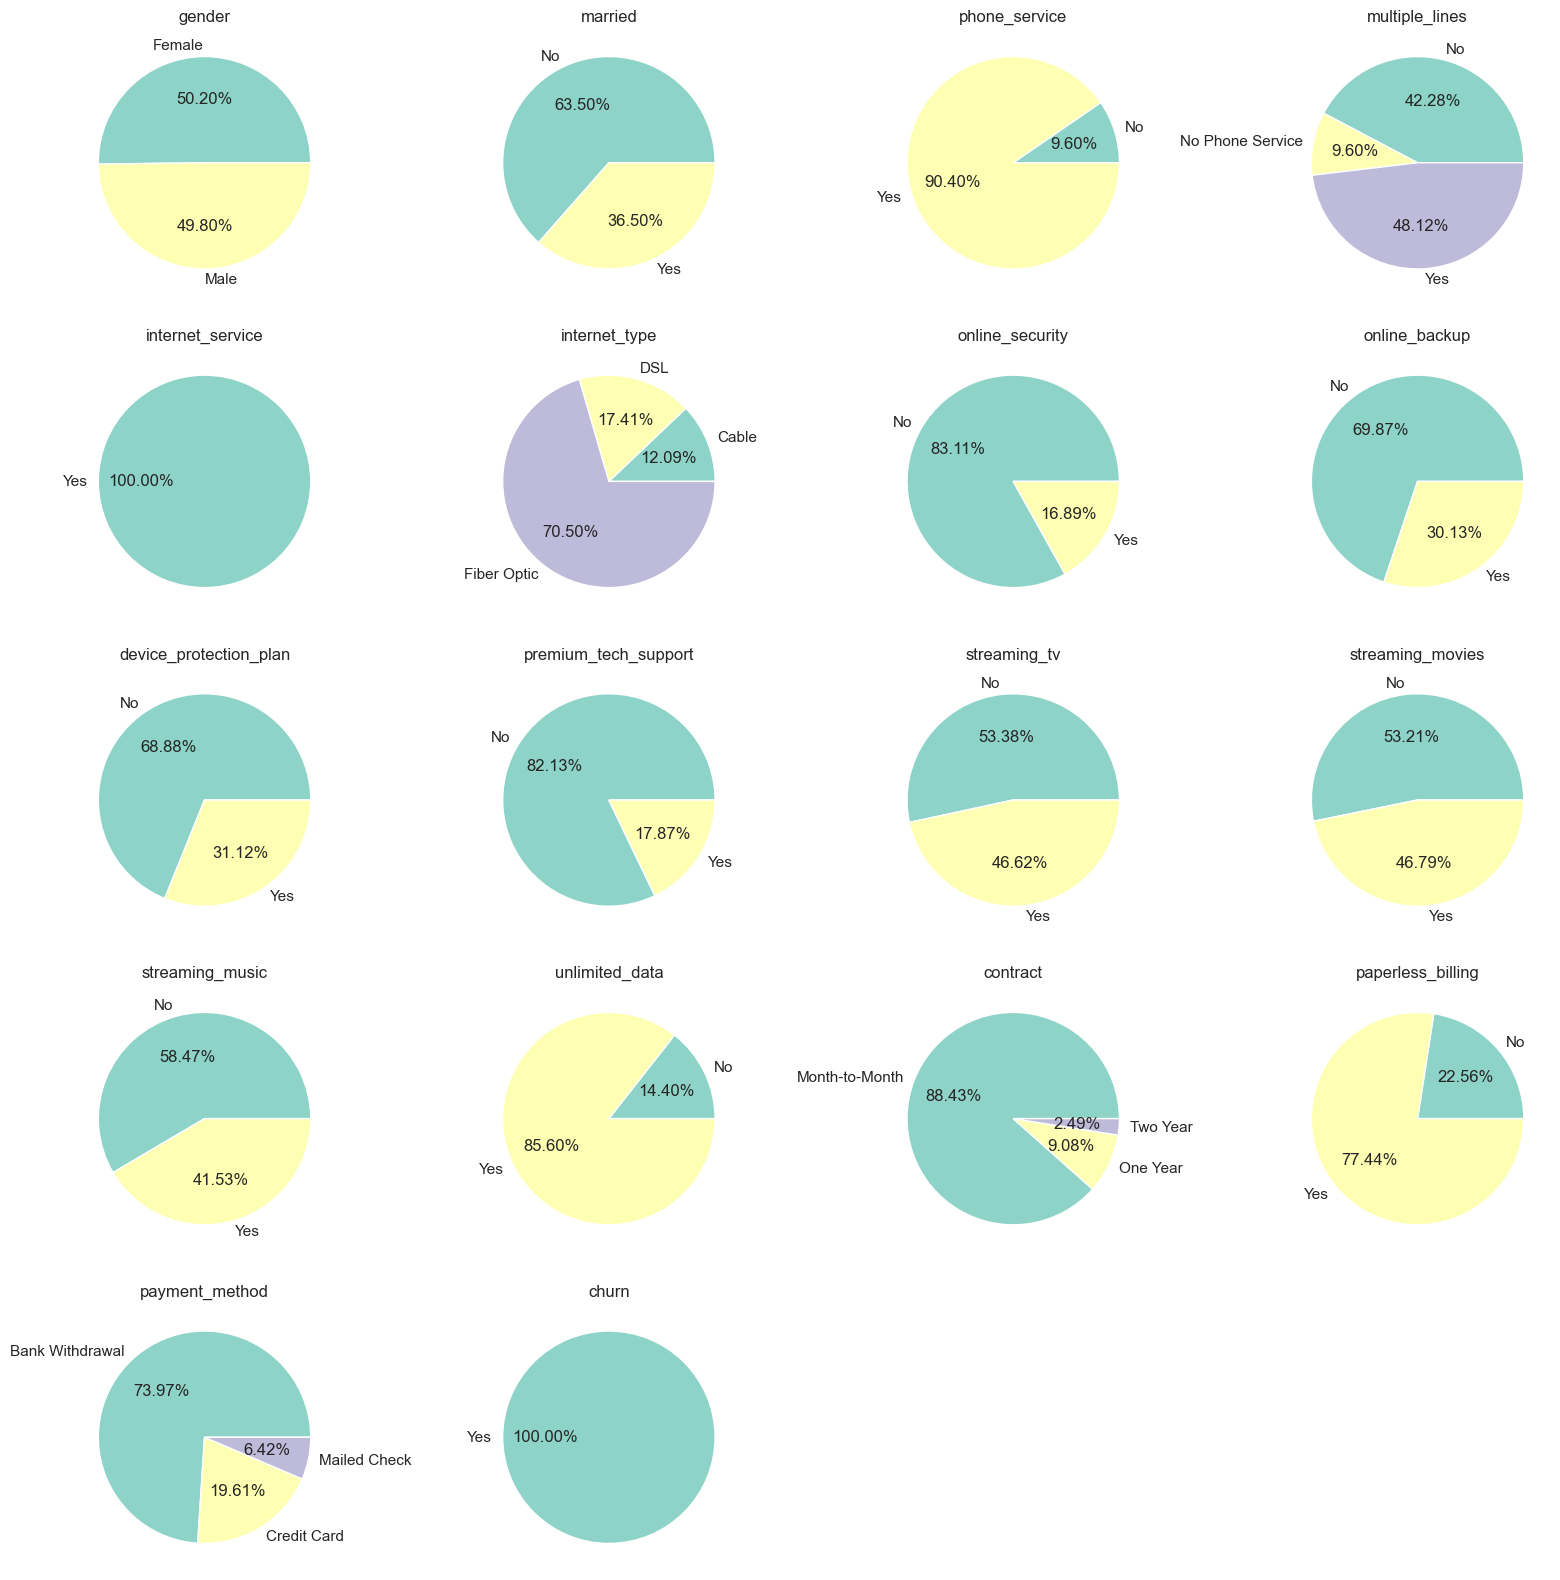

In [29]:
col = [col for col in internet_df.columns if internet_df[col].nunique() < 5 and internet_df[col].dtype == 'object']
ratio = internet_df[col]
churned = internet_df[internet_df.churn == 'Yes']

fig = plt.figure(figsize = (20, 20))
i = 1

for col in ratio.columns:
    plt.subplot(5, 4, i)
    ax = churned.groupby([col]).size().plot(kind = 'pie', autopct = '%.2f%%', colors = palette)
    ax.set(xlabel = None, ylabel = None)
    plt.title(str(col), loc = 'center', fontsize = 12)
    i += 1
plt.show()

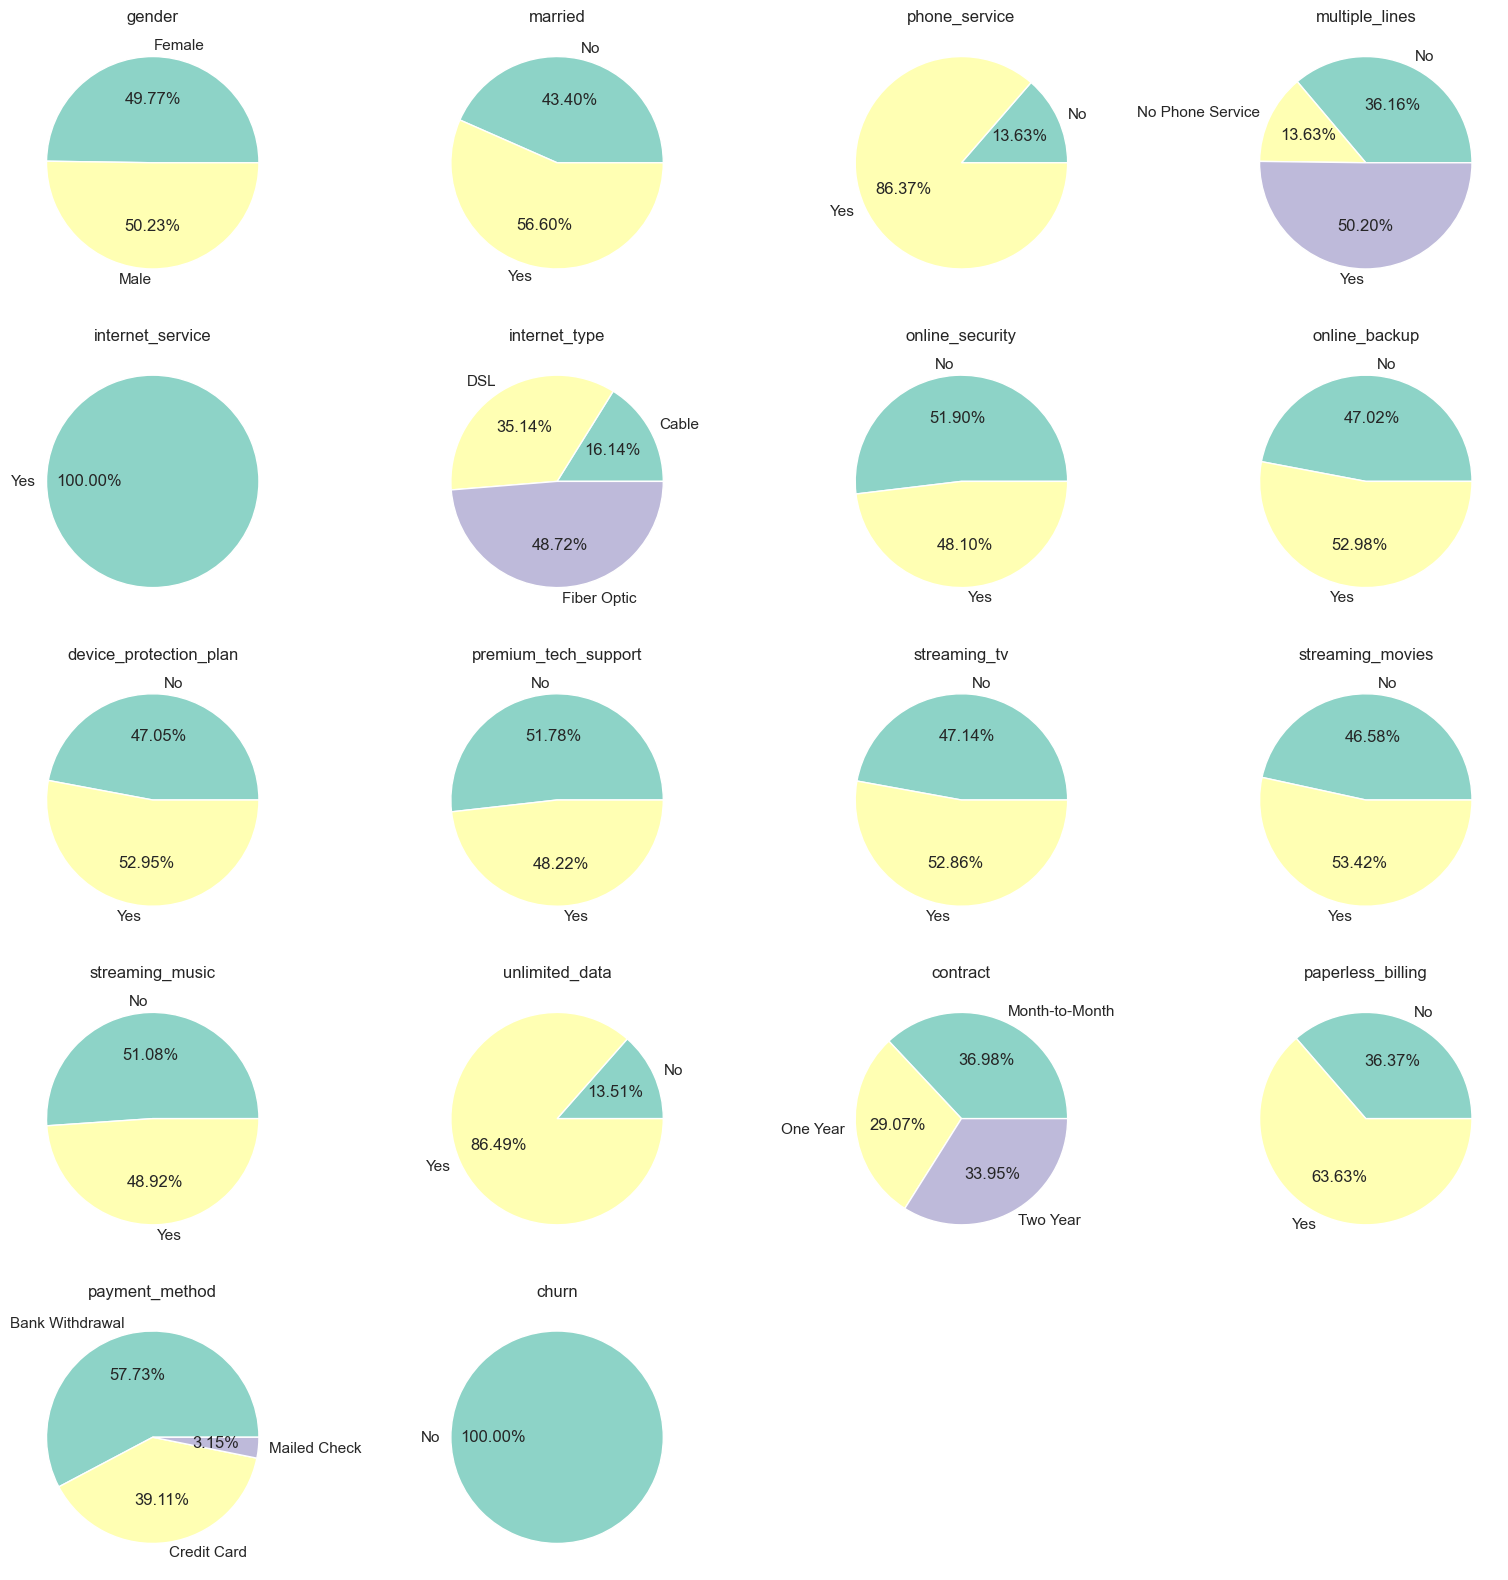

In [30]:
col = [col for col in internet_df.columns if internet_df[col].nunique() < 5 and internet_df[col].dtype == 'object']
ratio = internet_df[col]
stayed = internet_df[internet_df.churn == 'No']

fig = plt.figure(figsize = (20, 20))
i = 1

for col in ratio.columns:
    plt.subplot(5, 4, i)
    ax = stayed.groupby([col]).size().plot(kind = 'pie', autopct = '%.2f%%', colors = palette)
    ax.set(xlabel = None, ylabel = None)
    plt.title(str(col), loc = 'center', fontsize = 12)
    i += 1
plt.show()

- 인터넷 부가서비스 **online security, online backup, device protection plan, premium tech support** 에 대해서 *이탈 고객*은 이러한 부가서비스를 구독하지 않는 것을 확인했다.
- 유지 고객들의 프로필에서 이러한 부가서비스를 사용하는 비율은 절반에 해당한다.
- 인터넷 부가서비스를 구독하는 것이 이탈을 막아주지는 않지만, 점진적으로는 통신사를 유지하도록 하는 데에 영향을 미칠 수 있다고 추측할 수 있다. 

### 유지기간과 계약 종류에 따른 이탈율 변화

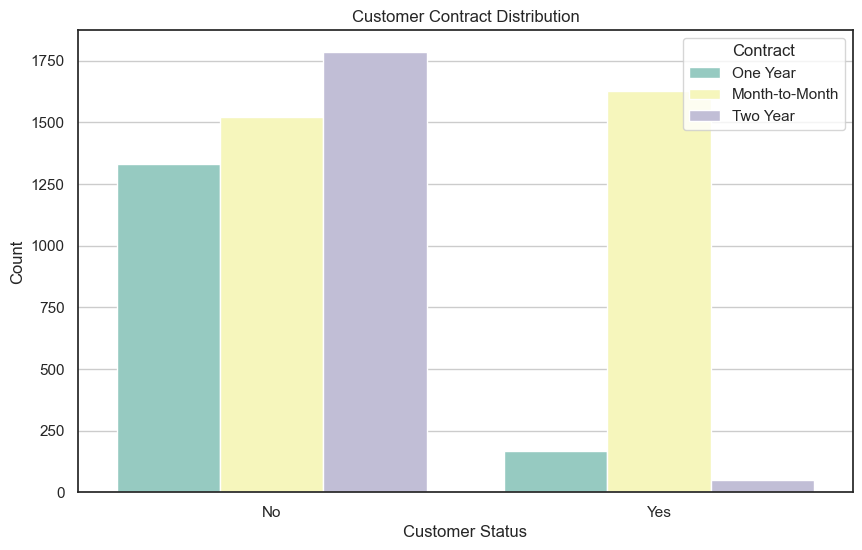

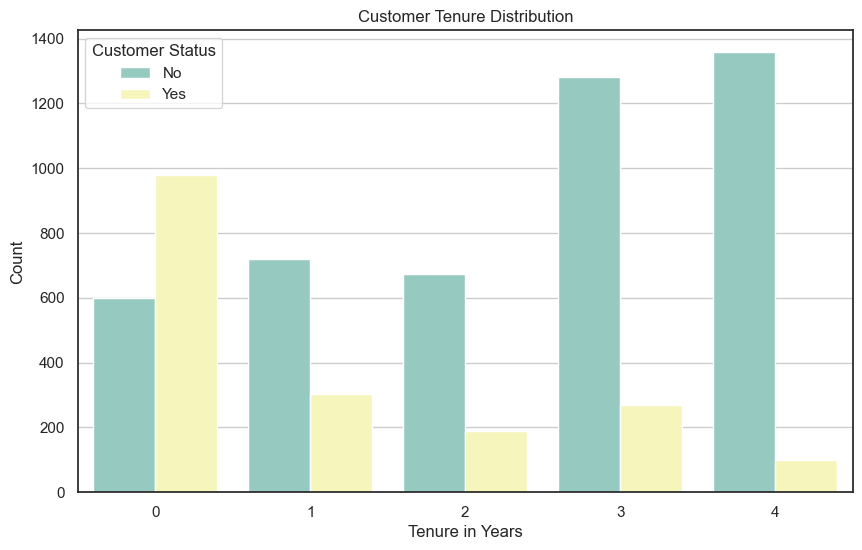

In [31]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='churn', hue='contract', palette = palette)
plt.title('Customer Contract Distribution')
plt.xlabel('Customer Status')
plt.ylabel('Count')
plt.legend(title = 'Contract')
plt.grid(axis = 'y')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='tenure_in_years', hue='churn', palette = palette)
plt.title('Customer Tenure Distribution')
plt.xlabel('Tenure in Years')
plt.ylabel('Count')
plt.legend(title = 'Customer Status')
plt.grid(axis = 'y')
plt.show()

<AxesSubplot: xlabel='tenure_in_years', ylabel='contract'>

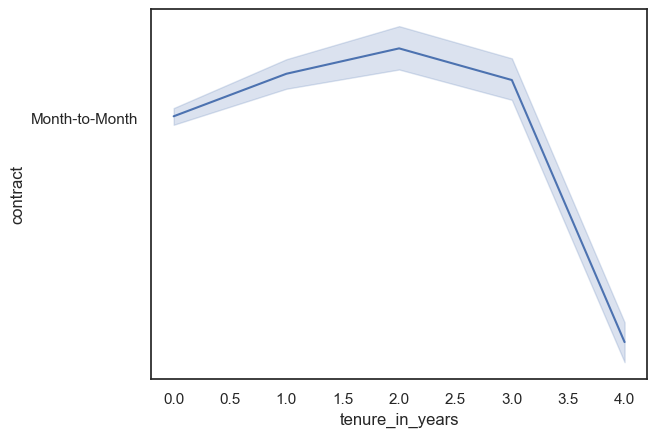

In [32]:
sns.lineplot(data = df, x = 'tenure_in_years', y = 'contract')

두 그래프를 통해 알 수 있는 것
- 월 계약자들의 이탈 비율이 월등히 높다.
- 12개월 미만 tenure 고객들의 이탈율이 가장 높다.
- 12개월 이상 ~ 24개월 미만 사용자의 이탈율이 다음으로 높다.
- 24개월 이상 ~ 36개월 미만 사용자의 이탈율은 그 다음으로 높다.
- 3년이상 사용하면서부터 이탈율이 줄어들기 시작한다.


### 변수 간의 상관관계

<AxesSubplot: xlabel='tenure_in_months', ylabel='total_revenue'>

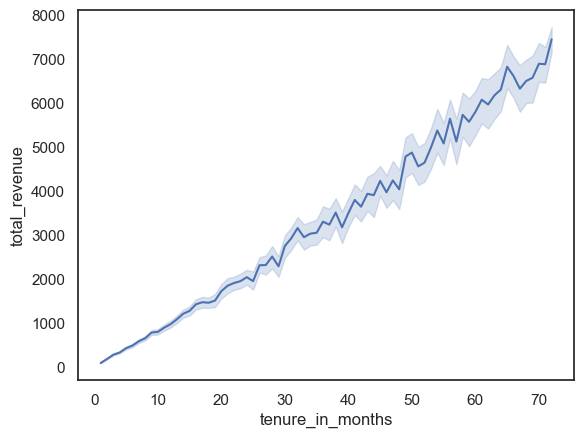

In [33]:
sns.lineplot(data = df, x='tenure_in_months', y='total_revenue')

<AxesSubplot: xlabel='tenure_in_months', ylabel='monthly_charge'>

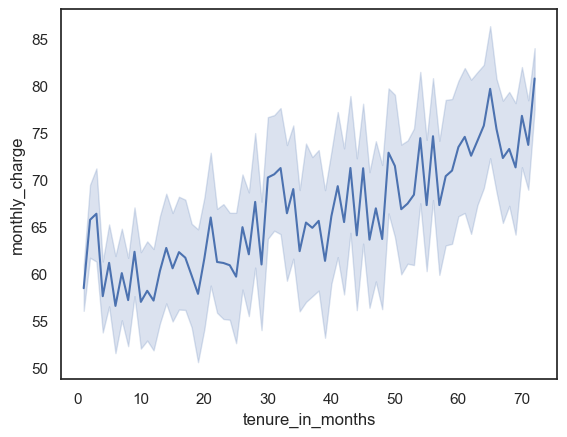

In [34]:
sns.lineplot(data = df, x='tenure_in_months', y='monthly_charge')

<AxesSubplot: xlabel='tenure_in_months', ylabel='number_of_referrals'>

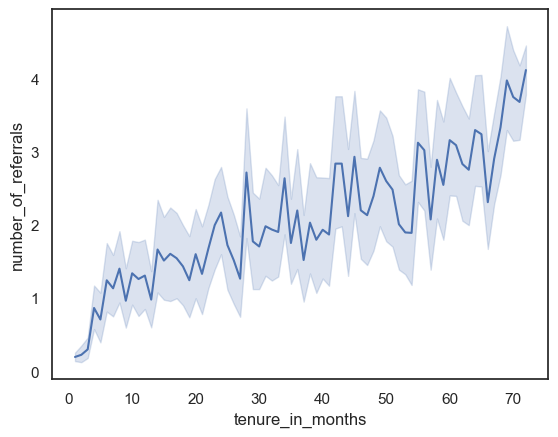

In [35]:
sns.lineplot(data = df, x = 'tenure_in_months', y = 'number_of_referrals')

- Positive correlation between monthly charge and tenure.
- Positive correlation between tenure and number of referrals.

In [36]:
df['monthly_charge'].describe()

count    6475.000000
mean       66.272008
std        29.917730
min        18.250000
25%        40.575000
50%        72.900000
75%        90.600000
max       118.750000
Name: monthly_charge, dtype: float64

In [37]:
df['total_revenue'].describe()

count     6475.000000
mean      3241.756360
std       2856.646045
min         21.610000
25%        836.300000
50%       2388.330000
75%       5116.720000
max      11979.340000
Name: total_revenue, dtype: float64

In [38]:
df.groupby('churn')['total_revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
churn,,,,,,,,
No,4636.0,3739.647138,2854.498240,73.65,1308.72,2968.90,5860.895,11979.34
Yes,1839.0,1986.605927,2448.320219,21.61,178.75,913.39,2925.075,11195.44


In [39]:
df.groupby('churn')['total_charges'].describe()

,count,mean,std,min,25%,50%,75%,max
churn,,,,,,,,
No,4636.0,2791.574912,2304.430637,55.70,836.1375,1948.875,4542.0125,8672.45
Yes,1839.0,1544.354676,1899.130559,18.85,137.9000,713.000,2349.8500,8684.80


In [40]:
df.groupby(['married', 'churn'])['monthly_charge'].describe()

count       mean        std    min      25%     50%      75%  \
married churn                                                                  
No      No     2032.0  59.747539  30.161892  18.25  25.0500  60.975  84.8625   
        Yes    1179.0  71.644529  24.660948  18.85  53.8750  75.900  90.1000   
Yes     No     2604.0  65.465668  31.712851  18.40  25.7875  70.550  92.5500   
        Yes     660.0  79.943561  23.603828  19.00  70.1000  85.000  98.7875   

                  max  
married churn          
No      No     118.65  
        Yes    118.35  
Yes     No     118.75  
        Yes    117.80

- 기혼인 사람들의 이탈율이 확연히 적다.
- 미혼인 사람들을 위한 마케팅이 필요할 수 있다.

In [41]:
df.groupby(['age_range', 'churn'])['monthly_charge'].describe()

count       mean        std    min      25%     50%  \
age_range churn                                                        
20        No     899.0  61.030478  31.159919  18.80  25.0000  63.850   
          Yes    276.0  73.081341  25.414205  19.40  54.3500  75.950   
30        No     836.0  61.447488  31.034914  18.55  25.0875  62.975   
          Yes    291.0  71.679038  25.695807  19.10  50.7500  77.950   
40        No     909.0  58.717272  31.411368  18.80  24.5000  59.800   
          Yes    319.0  71.996865  25.190226  19.00  53.2000  78.450   
50        No     847.0  60.722668  31.216474  18.25  24.8000  64.500   
          Yes    310.0  73.609839  25.275828  18.85  55.4375  78.775   
60        No     680.0  63.938015  30.658608  18.40  26.1000  69.575   
          Yes    293.0  76.587201  24.519243  18.95  68.9500  83.650   
70        No     465.0  80.342258  25.476781  19.35  67.4500  85.700   
          Yes    350.0  79.932857  20.881521  19.45  71.0125  83.950   

                      75%     max  
age_range churn                    
20        No      86.8000  118.60  
          Yes     94.2000  116.20  
30        No      89.2625  118.75  
          Yes     90.3500  117.80  
40        No      85.3000  117.20  
          Yes     90.9250  113.60  
50        No      85.9750  118.65  
          Yes     94.4000  118.35  
60        No      89.7125  118.20  
          Yes     95.2500  113.20  
70        No     100.4000  117.35  
          Yes     95.2125  117.45

- 연령대 자체가 이탈에 영향을 주지는 않는 것을 보여준다.
- 70 (69 이상) 연령대에서 churning 비율이 증가했음을 알 수 있다.

# 5. 목표 변수 확인
- 기존 프로젝트에서는 목표 변수를 확인해 변수 간의 특징을 확인해보지 않았다. 따라서 개인적으로 목표 변수를 설정해 이탈 고객과 기존 고객의 특징을 분석해 어떤 인사이트를 제공할 수 있을지 추가적인 분석을 실행했다.
- '이탈 고객'을 목표 변수로 두고, 이탈 고객과 비교할 대상이 되는 기존 고객에는 세 가지의 기준을 잡았다.
    - Customers who contributed above the average revenue of the company
    - Customers who recommended the company to more than 2 acquaintances
    - Customers who stay above the average tenure period of all the customers
- Customers who **contributed above the average revenue of the company** and those who **stay** are treated as **high value customers**.

In [42]:
df['high_value'] = 0
df.loc[(df['total_revenue'] > df.total_revenue.mean()) &
       (df['churn'] == 'No'), 'high_value'] = 1
df.high_value.value_counts()

0    4315
1    2160
Name: high_value, dtype: int64

In [43]:
df_highvalue = df[df.high_value == 1]

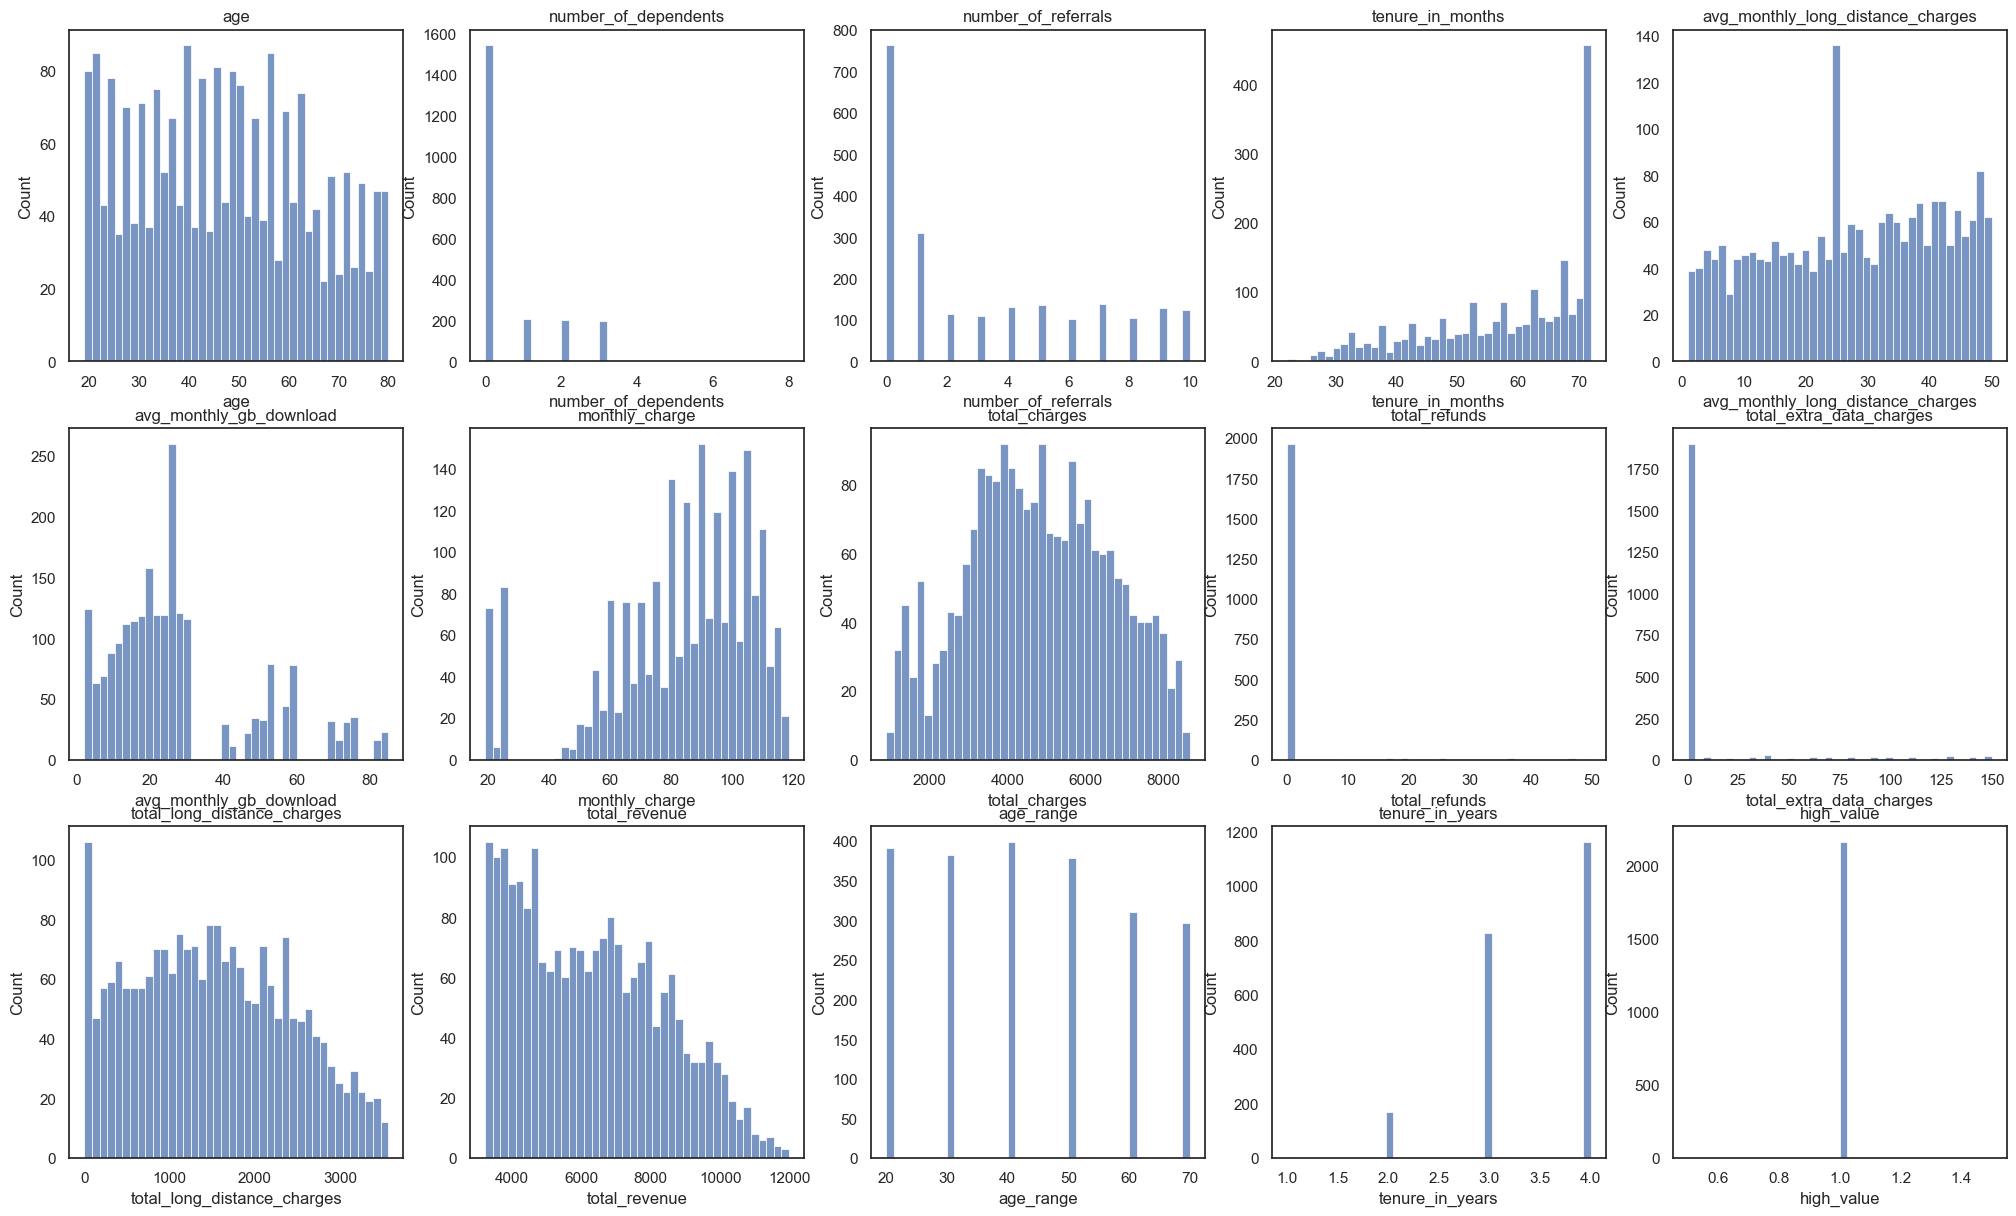

In [44]:
num_col = [col for col in df_highvalue.columns if df_highvalue[col].dtype in ['int64', 'float64']]
plt.figure(figsize = (25, 25))

for i, col in enumerate(num_col):
    plt.subplot(5, 5, i + 1)
    ax = sns.histplot(x = str(col), data = df_highvalue, palette = palette, bins = 40)
    ax.set_title(str(col))

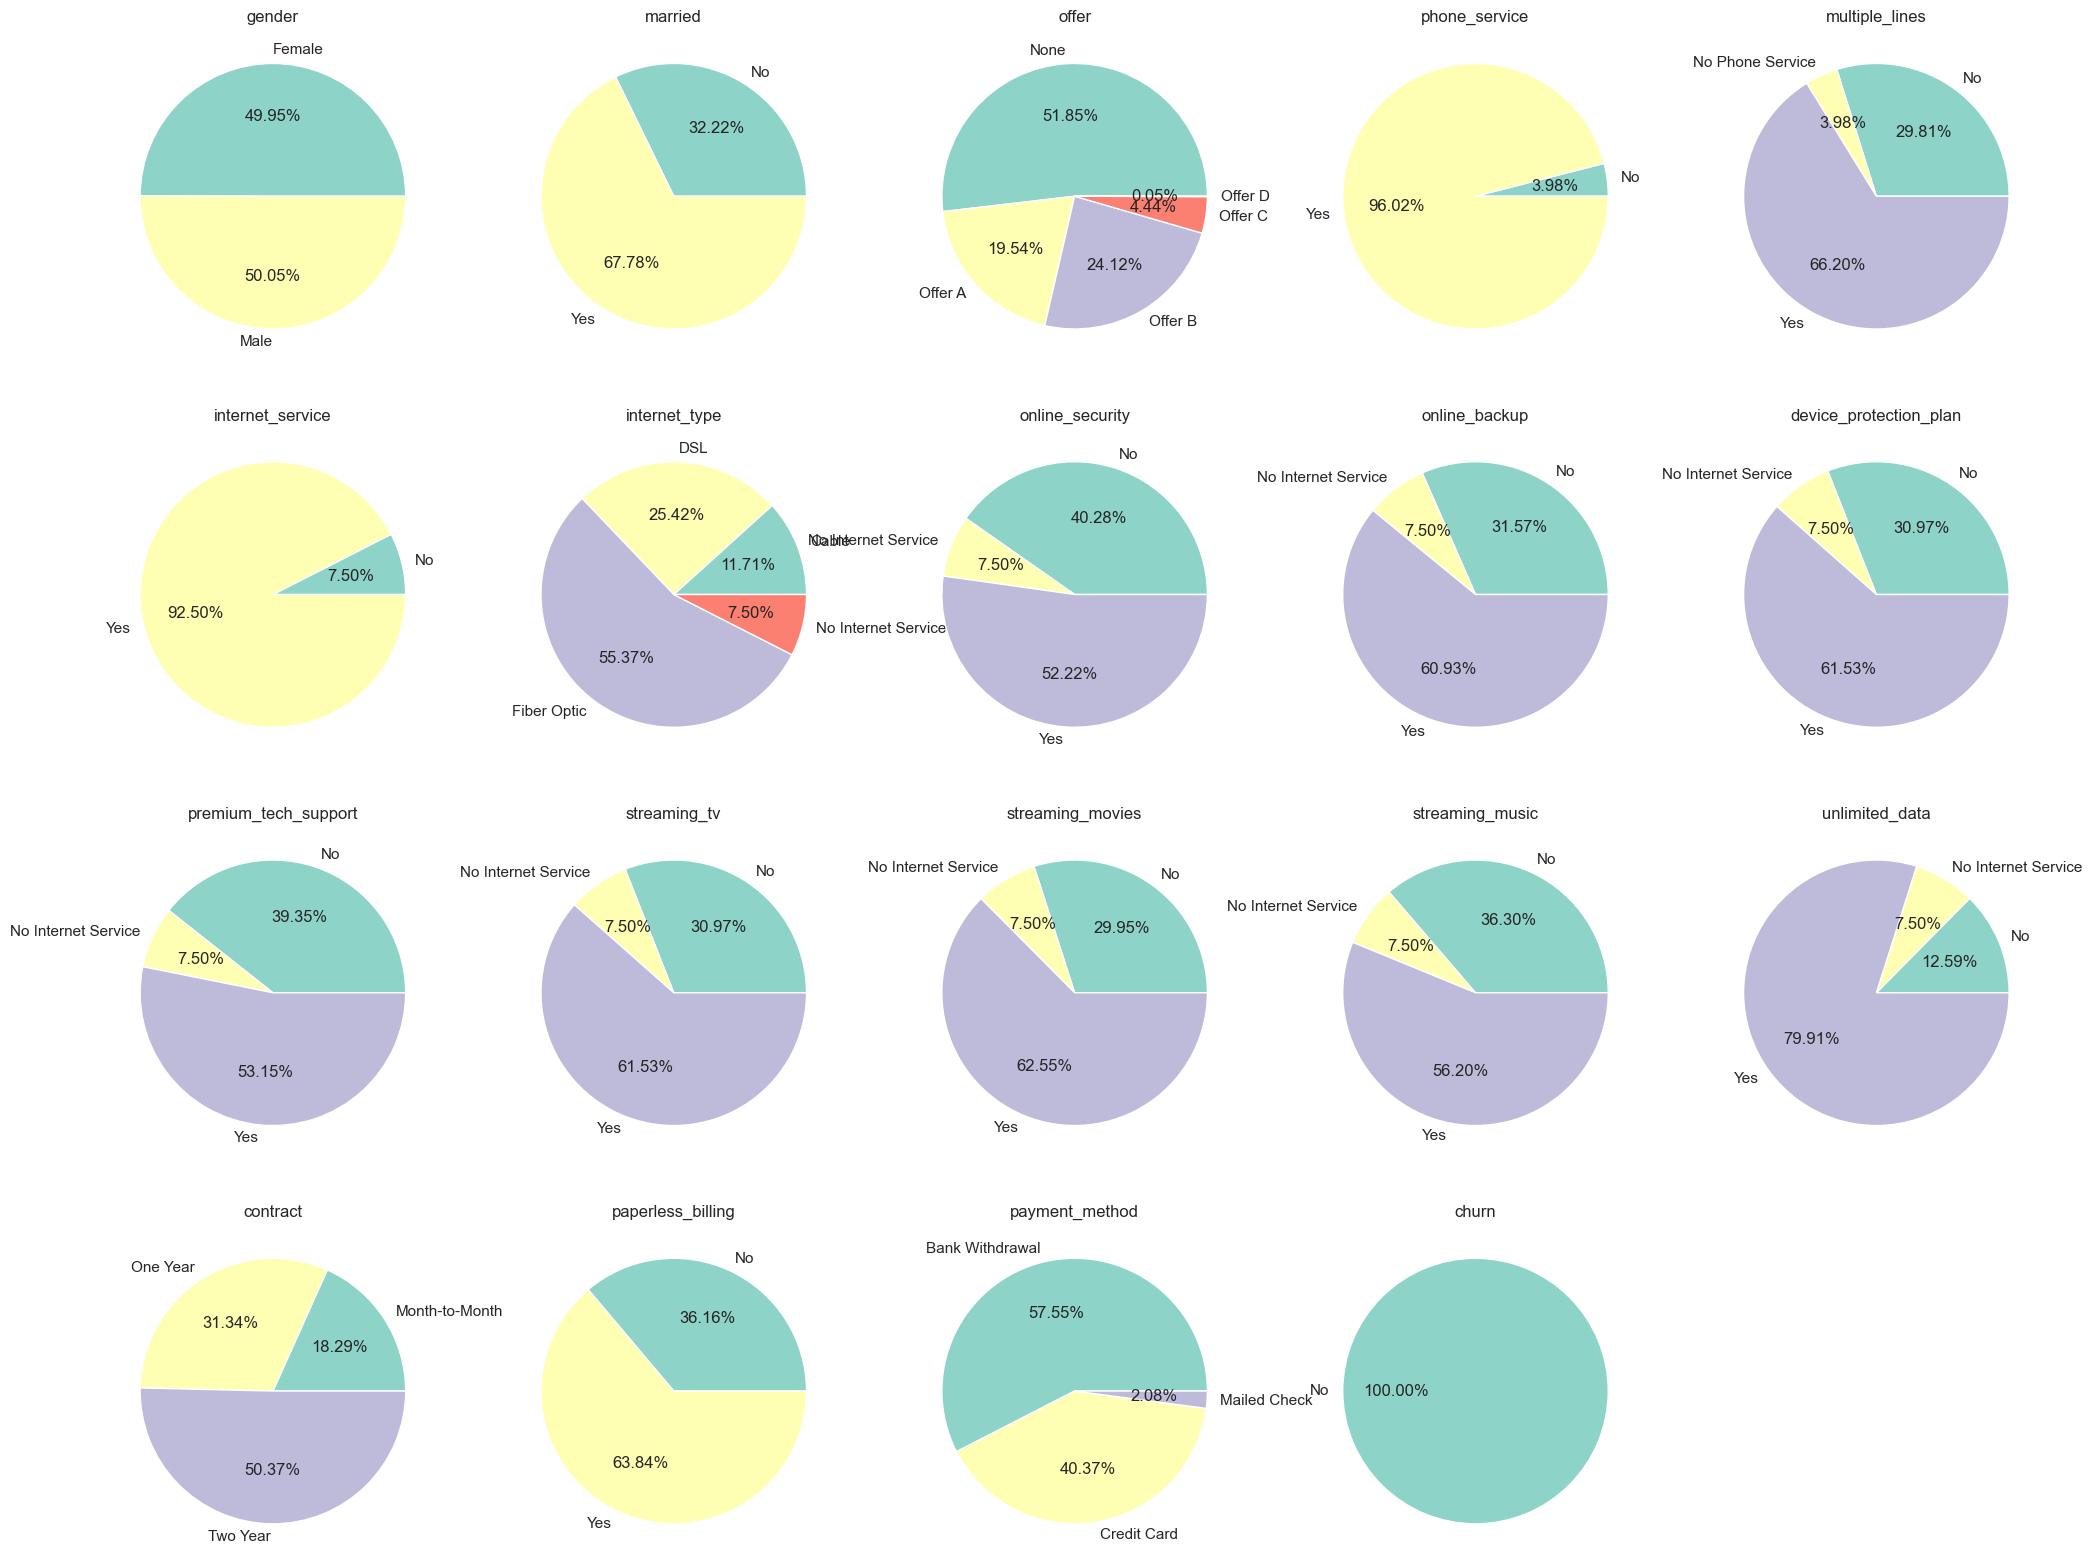

In [45]:
obj_col = [col for col in df_highvalue.columns if df_highvalue[col].dtype == 'object' and df_highvalue[col].nunique() < 10]
plt.figure(figsize = (25, 25))

for i, col in enumerate(obj_col):
    plt.subplot(5, 5, i + 1)
    ax = df_highvalue.groupby([col]).size().plot(kind = 'pie', autopct = '%.2f%%', colors = palette)
    plt.title(str(col), loc = 'center')

- **Churn customers**

In [46]:
df_churned = df.loc[df['churn'] == 'Yes']

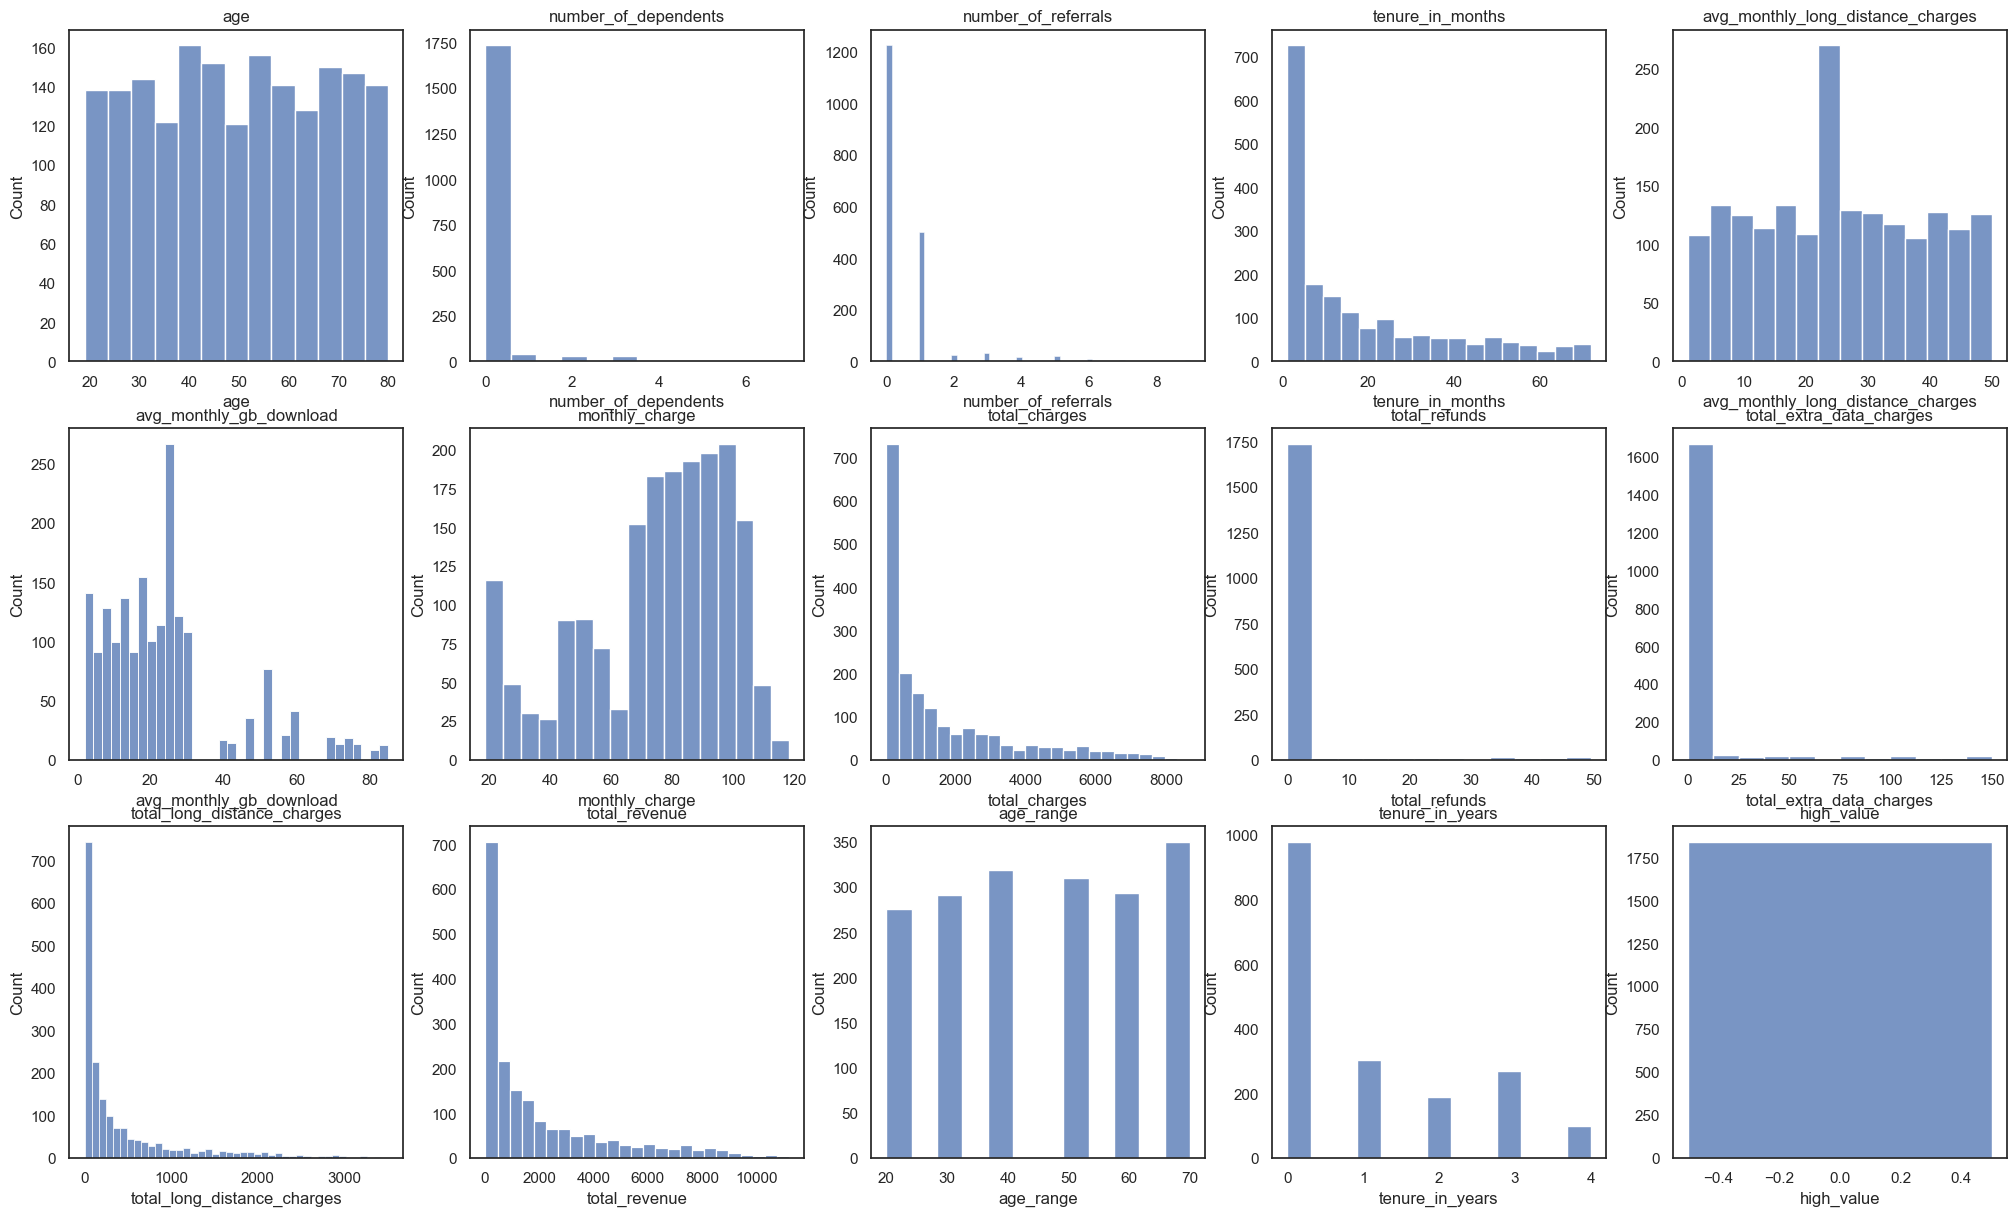

In [47]:
num_col = [col for col in df_churned.columns if df_churned[col].dtype in ['int64', 'float64']]
plt.figure(figsize = (25, 25))

for i, col in enumerate(num_col):
    plt.subplot(5, 5, i + 1)
    ax = sns.histplot(x = str(col), data = df_churned, palette = palette)
    ax.set_title(str(col), loc = 'center')

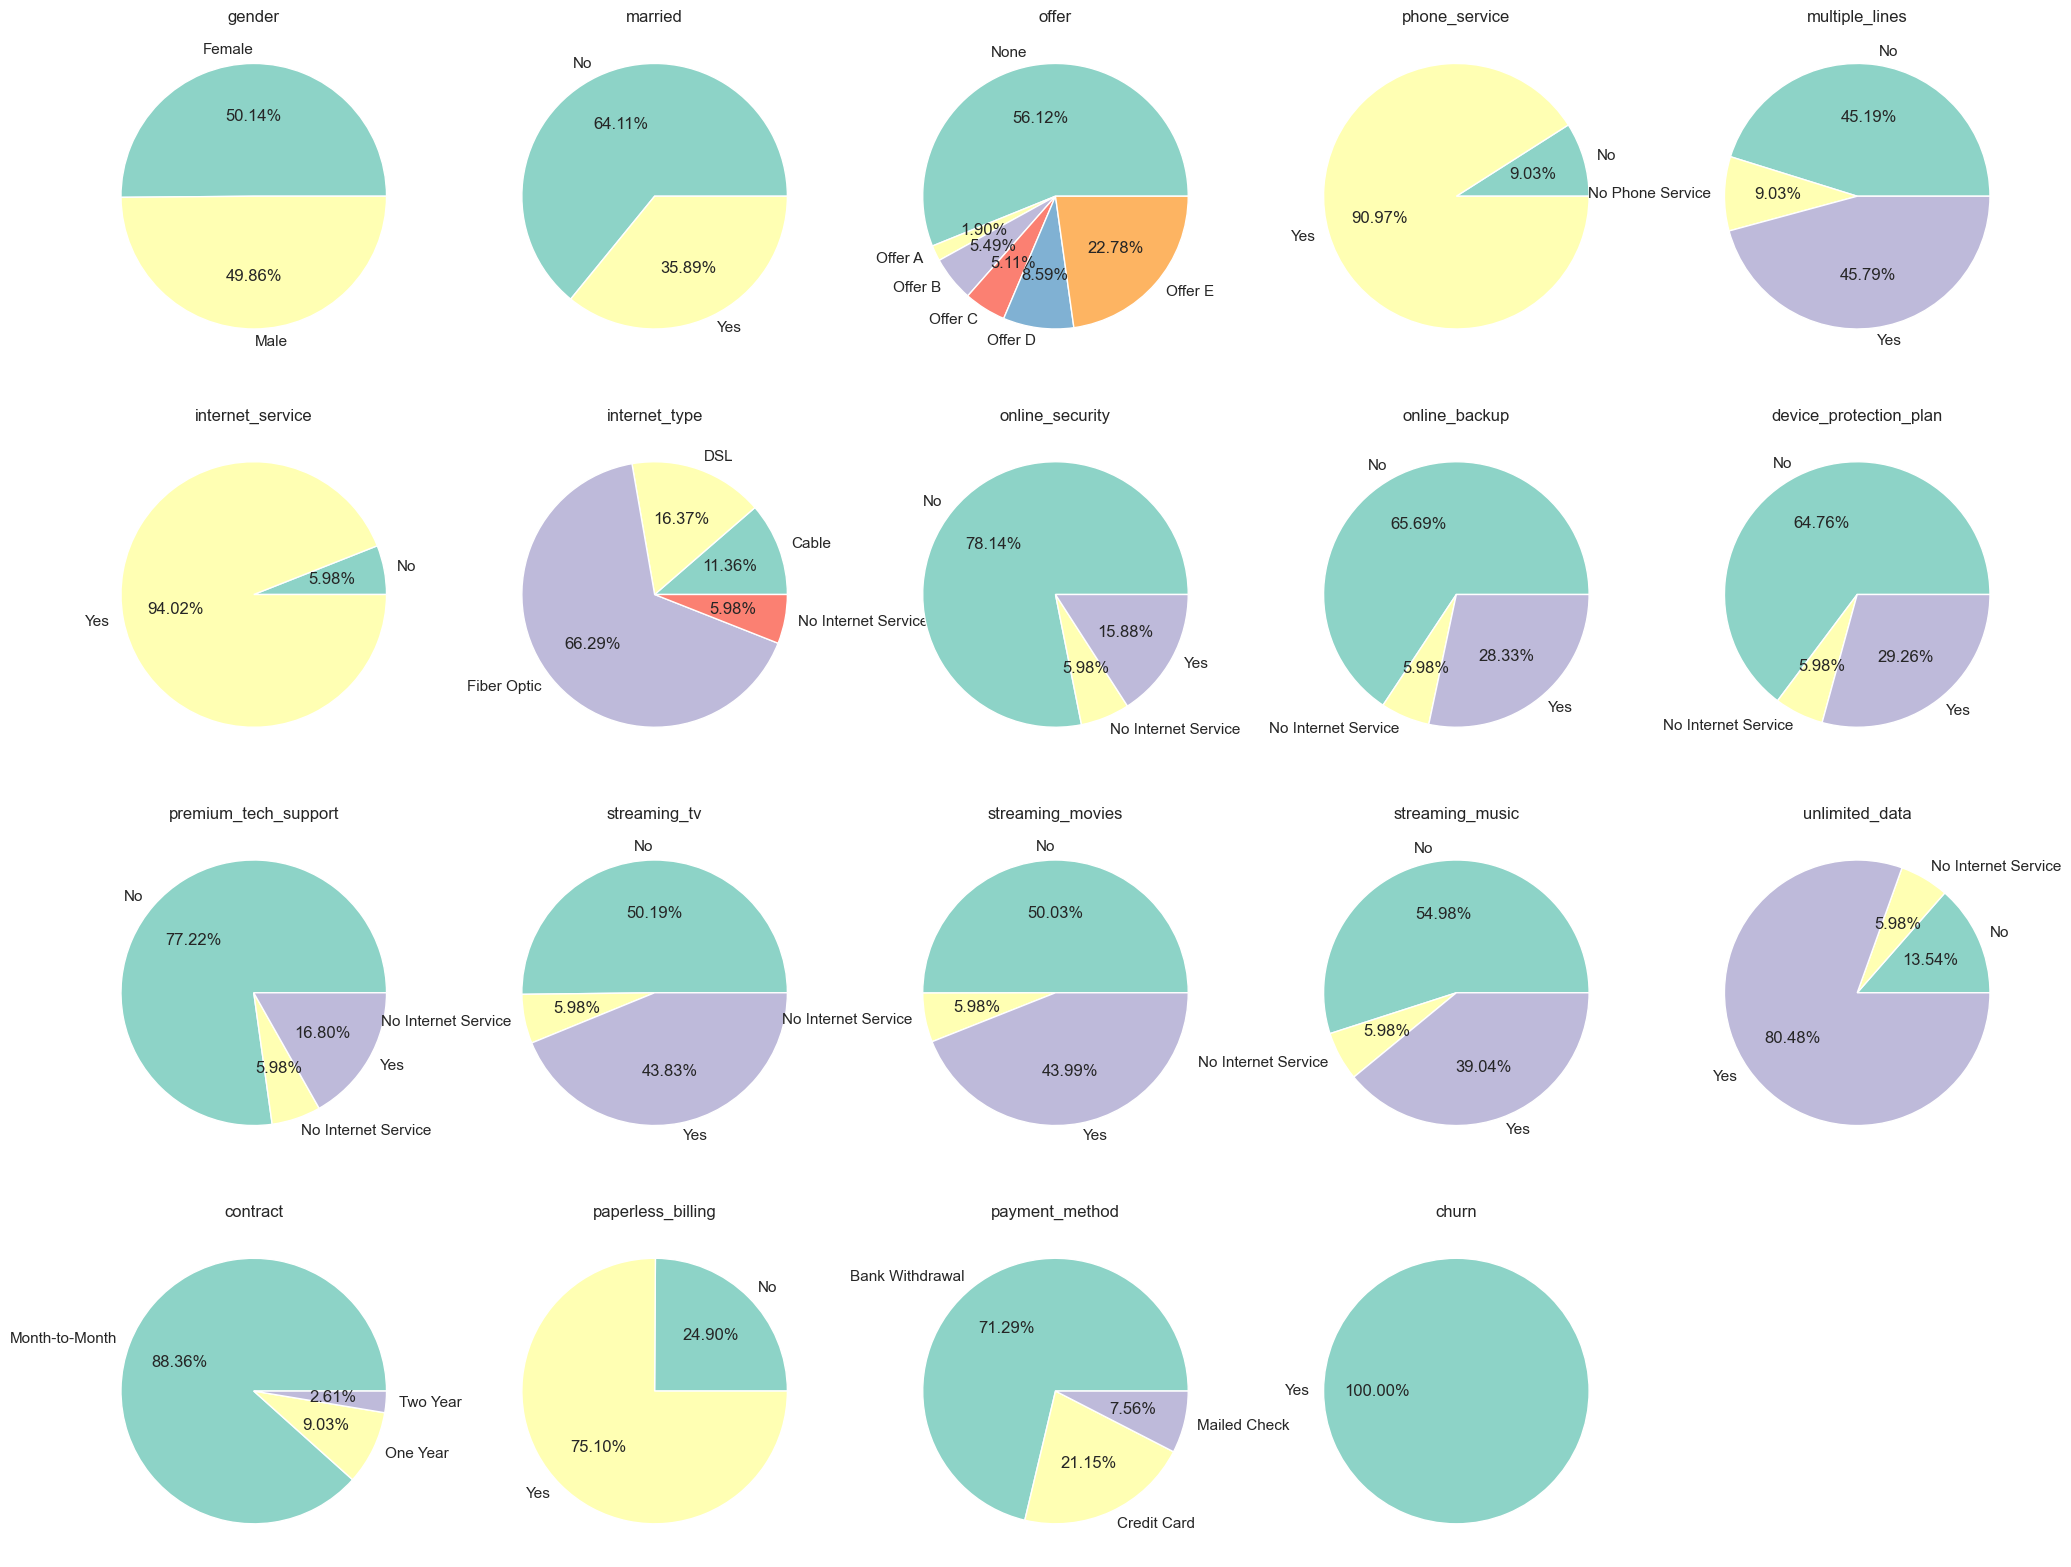

In [48]:
obj_col = [col for col in df_churned.columns if df_churned[col].dtype == 'object' and df_churned[col].nunique() < 10]
plt.figure(figsize = (25, 25))

for i, col in enumerate(obj_col):
    plt.subplot(5, 5, i + 1)
    ax = df_churned.groupby([col]).size().plot(kind = 'pie', autopct = '%.2f%%', colors = palette)
    plt.title(str(col), loc = 'center')

### Comparison between High value vs. Churned Customers

**충성 고객 특징**
- 기혼의 비율 **67.78%**
- **Offer E** 구독자가 없음.
- 50% 이상의 고객이 추가적인 인터넷 서비스를 구독하고 있음 (**backup, security, protection plan, tech support** ).
- 약 60% 이상의 고객이 추가적인 스트리밍 서비스를 구독하고 있음(**TV, movies, music** ).
- **50.37%** 의 고객이 2년 계약, **31.34%** 의 고객이 1년 계약으로 통신사를 이용하기 시작했음 (총 **81.71%** )<br><br>

**이탈 고객 특징**
- 미혼의 비율이 **64.11%**
- **Offer E**를 구독하는 고객 비율이 **22.78%**
    - 기업은 Offer E의 취약점을 확인할 필요성이 있다. 관련 마케팅 오퍼에 대해서도 철저한 검토가 필요하다.
- **최소 60% - 최대 80%** 에 해당하는 고객이 추가적인 인터넷 부가서비스를 이용하지 않음.
- **88.36%** 에 해당하는 고객들은 월 계약으로 통신사를 이용하고 있음.<br><br>

**공통점**
- 성별은 이탈율에 영향을 미치지 않는다.
- 인터넷 서비스를 이용하는 대부분의 고객들이 Fiber optic 인터넷 서비스를 이용하고 있다.
- 대다수의 고객들이 무제한 데이터를 사용한다.
- 대다수의 고객들이 전자영수증을 선호하고, bank withdrawal로 요금을 지불하는 것을 선호한다. <br><br>

**제안**
- 대부분의 고객들이 마케팅 제안을 구독하지 않는 것으로 보아 기업은 낮은 마케팅율을 보이고 있다. 따라서 기업은 마케팅 효과를 상승시키기 위한 전략을 세우는 것이 좋다.
    - 충성 고객들의 경우 통신사에게 기여하고 있는 금액이 타 고객에 비교하면 월등히 많기 때문에 이들을 대상으로 하는 VIP 프로그램을 만들거나, VIP 보상 서비스를 만드는 것을 고려해볼 수 있다.
    - 이탈 고객의 64% 이상이 미혼인 고객이고, 부양가족이 없는 고객이 거의 대부분이다. 가족 간 결합 서비스처럼 개인에게도 알뜰한 사용을 위한 개인 결합 서비스를 만들어 제공하는 것을 고려해볼 수 있다 (e.g., Streaming Service 간 결합 서비스).
- 현재 월 계약 고객들은 이탈 위험성이 있는 고객들로 분류할 수 있다. 따라서 그들을 장기간 계약 구독자로 변경할 수 있도록 해야한다. 이는 상위 통계 결과로 보았을 때 이탈 위험을 막아줄 수 있다.
- 인터넷 부가서비스에 대한 적절한 홍보와 마케팅이 필요하다. 절반 이상의 충성 고객들은 인터넷 부가서비스를 추가적으로 이용하고 있지만 대부분의 이탈 고객들은 인터넷 부가서비스를 이용하지 않고 있다. 인터넷 부가서비스를 이용한다고 해서 이탈 위험을 완전히 막을 수 있는 것은 아니지만, 점진적으로 이탈율을 감소시킬 수 있는 것으로 보이기 때문에 결합상품 마케팅을 제안할 수 있다.

# 6. 데이터 인코딩

모델링을 위해 라벨 인코딩으로 결정
데이터 인코딩 후 상관관계 확인, 컬럼 선정하여 훈련세트와 테스트 세트 나눠 모델 학습

In [49]:
df.head()

,gender,age,married,number_of_dependents,number_of_referrals,tenure_in_months,offer,phone_service,avg_monthly_long_distance_charges,multiple_lines,...,monthly_charge,total_charges,total_refunds,total_extra_data_charges,total_long_distance_charges,total_revenue,churn,age_range,tenure_in_years,high_value
0,Female,37,Yes,0,2,9,None,Yes,42.39,No,...,65.6,593.30,0.0,0,381.51,974.81,No,30,0,0
2,Male,50,No,0,0,4,Offer E,Yes,33.65,No,...,73.9,280.85,0.0,0,134.60,415.45,Yes,50,0,0
3,Male,78,Yes,0,1,13,Offer D,Yes,27.82,No,...,98.0,1237.85,0.0,0,361.66,1599.51,Yes,70,1,0
4,Female,75,Yes,0,3,3,None,Yes,7.38,No,...,83.9,267.40,0.0,0,22.14,289.54,Yes,70,0,0
5,Female,23,No,3,0,9,Offer E,Yes,16.77,No,...,69.4,571.45,0.0,0,150.93,722.38,No,20,0,0


In [50]:
# Create a label encoder object
le = LabelEncoder()

# Label Encoding will be used for columns with 2 or less unique values
le_count = 0
for col in df.columns[1:]:
    if df[col].dtype == 'object':
        if df[col].nunique() <= 2:
            le.fit(df[col])
            df[col] = le.transform(df[col])
            le_count += 1
print('{} columns were label encoded.'.format(le_count))

5 columns were label encoded.


In [52]:
def encode_data(dataframe):
    if dataframe.dtype == "object":
        dataframe = LabelEncoder().fit_transform(dataframe)
    return dataframe

df = df.apply(lambda x: encode_data(x))
df.head()

,gender,age,married,number_of_dependents,number_of_referrals,tenure_in_months,offer,phone_service,avg_monthly_long_distance_charges,multiple_lines,...,monthly_charge,total_charges,total_refunds,total_extra_data_charges,total_long_distance_charges,total_revenue,churn,age_range,tenure_in_years,high_value
0,0,37,1,0,2,9,0,1,42.39,0,...,65.6,593.30,0.0,0,381.51,974.81,0,30,0,0
2,1,50,0,0,0,4,5,1,33.65,0,...,73.9,280.85,0.0,0,134.60,415.45,1,50,0,0
3,1,78,1,0,1,13,4,1,27.82,0,...,98.0,1237.85,0.0,0,361.66,1599.51,1,70,1,0
4,0,75,1,0,3,3,0,1,7.38,0,...,83.9,267.40,0.0,0,22.14,289.54,1,70,0,0
5,0,23,0,3,0,9,5,1,16.77,0,...,69.4,571.45,0.0,0,150.93,722.38,0,20,0,0


In [53]:
# Label Encoding 결과 재복원
# print(encoder.inverse_transform(df["married"]))

In [54]:
df = df.drop(['total_refunds'], axis = 1)

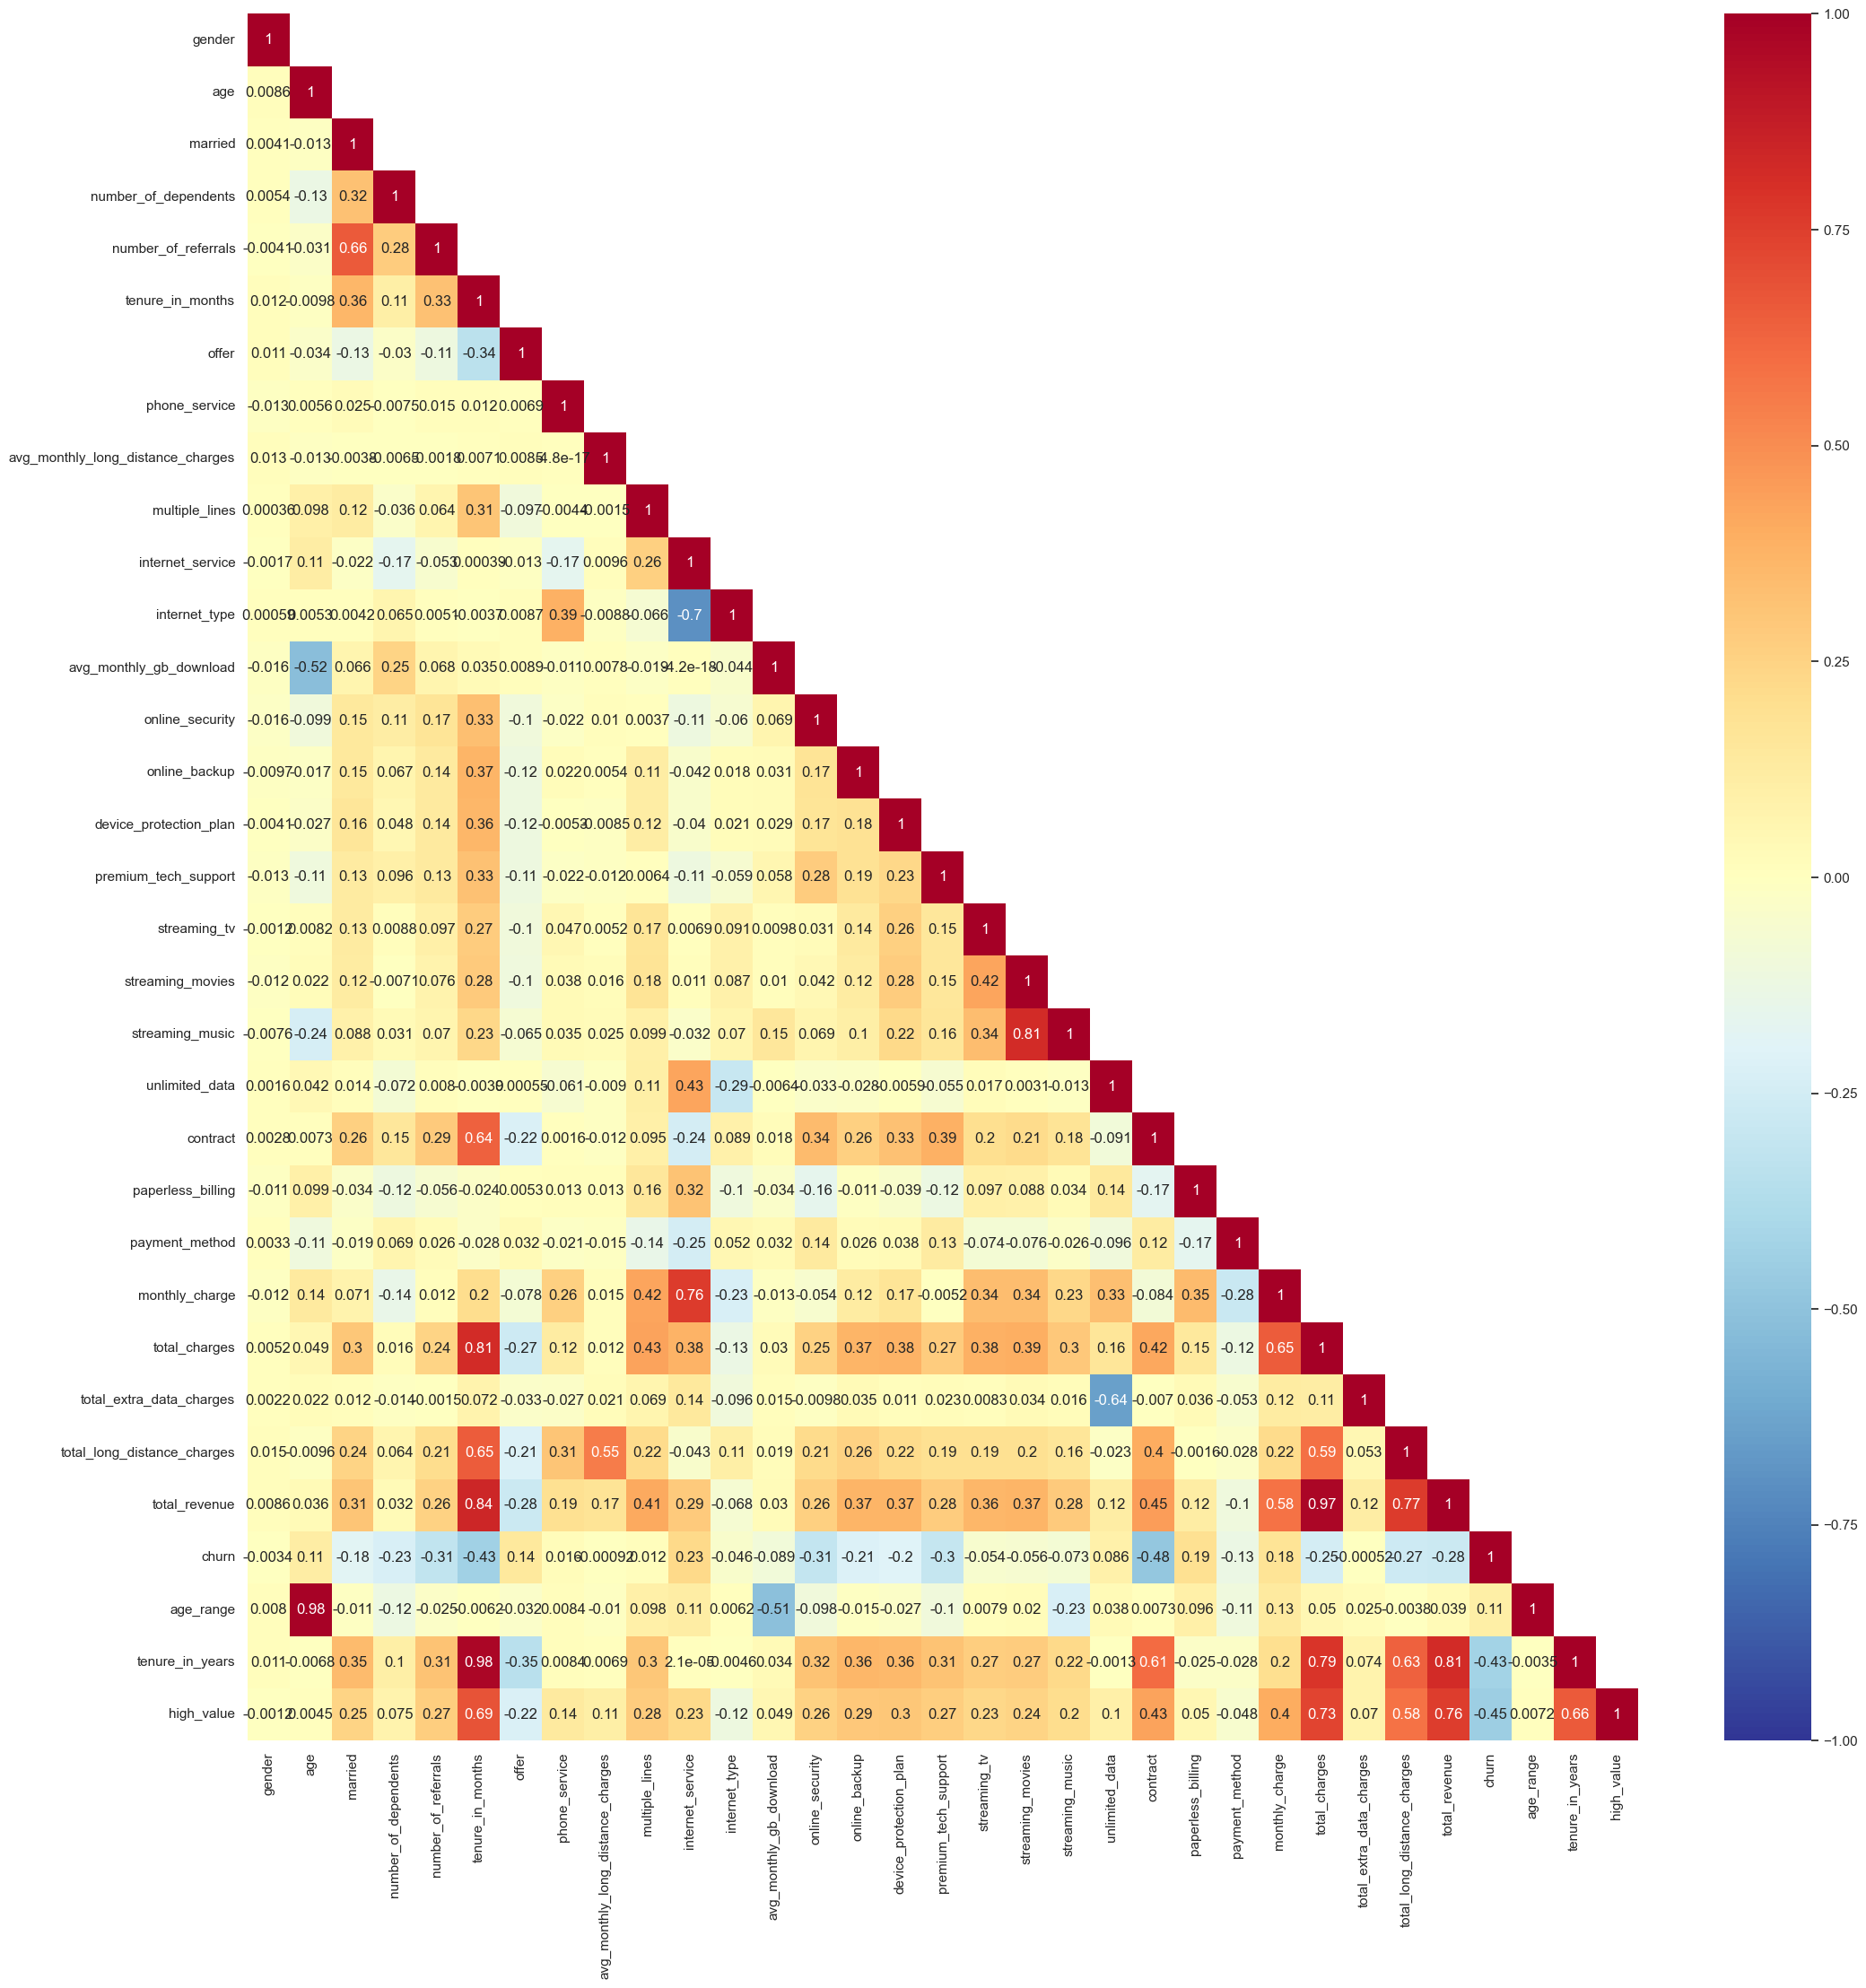

In [55]:
# 상관계수 시각화
raw = df.corr()
plt.figure(figsize = (25,25))
mask = np.array(raw)
mask[np.tril_indices_from(mask)] = False
sns.heatmap(raw,
              annot = True,# 실제 값 화면에 나타내기
              mask = mask,
            cmap = 'RdYlBu_r',  # Red, Yellow, Blue 색상으로 표시
              vmin = -1, vmax = 1, # 컬러차트 -1 ~ 1 범위로 표시
              )
plt.show()

### 고객 상태와 다른 독립 변수 간의 상관관계

<AxesSubplot: >

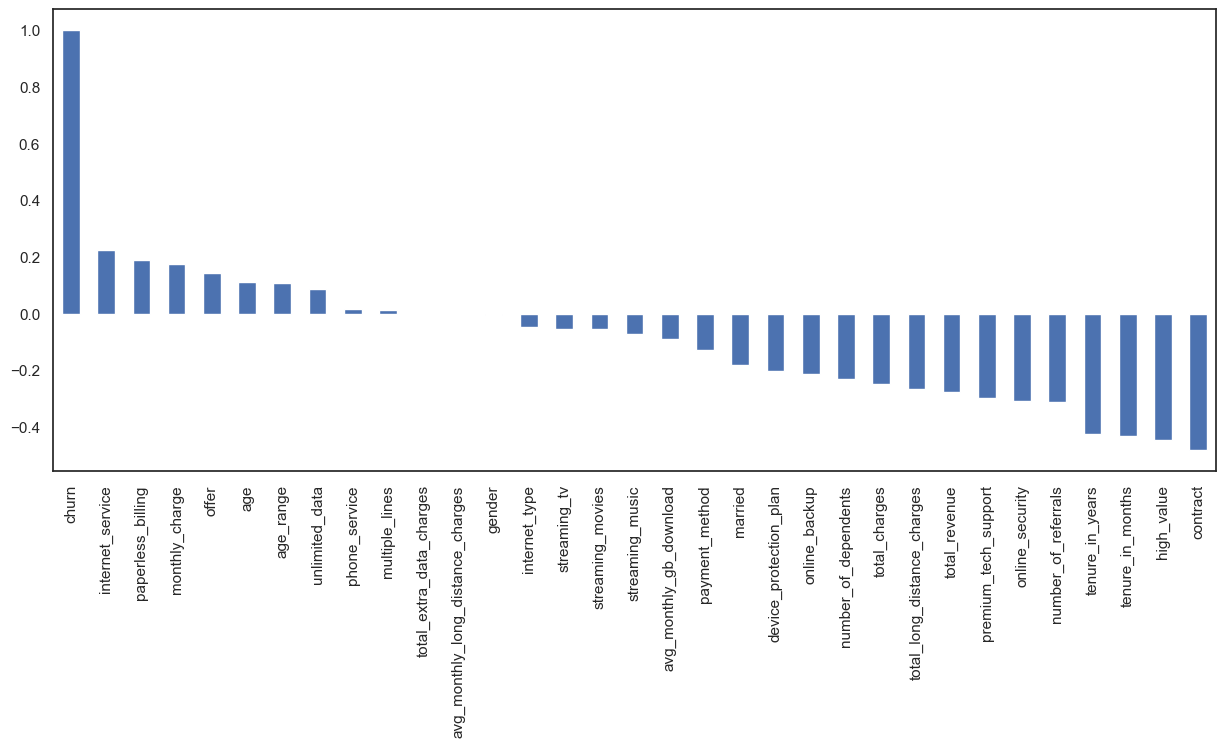

In [56]:
plt.figure(figsize=(15,6))
raw['churn'].sort_values(ascending = False).plot(kind='bar')

- 인터넷 서비스를 신청하고 있을수록
- 전자 영수증을 신청하고 있을수록?
- 월별 요금이 높을수록<br>
**이탈 가능성이 높다.**
<br><br>
- 유지 기간이 길수록
- 추천인 수가 많을수록
- 전체 소비 금액이 클수록
- 장거리 요금을 많이 부과할수록 (장거리 전화를 사용할수록)
- 부양가족이 많을수록<br>
**유지 가능성이 높다.**

In [59]:
# 데이터프레임 csv로 저장
df.to_csv('0703dataprep.csv', index=False)

이탈 고객 데이터가 충성 고객 데이터에 비해 너무 적어 불균형 데이터이므로 언더샘플링을 함

언더샘플링 : 충성고객 데이터가 회원 당 여러개가 아니라 딱 1개의 데이터만 남을 수 있도록 하는 것

데이터를 랜덤하게 섞은 후 중복을 제거


추가로 검증방법은 k-fold 교차 검증 방식이 많이 이용되고 있음

In [58]:
# test_size : 테스트 셋 구성의 비율
# 0.2는 전체 데이터 셋의 20%를 test셋으로 지정하겠다는 의미
# shuffle : default = True  split을 해주기 이전에 섞을 건지 여부
# stratify : classfication을 다룰 때 매우 중요한 옵션값
# 한쪽에 쏠려서 분배되는 것을 방지
# random_state : 세트를 섞을 때 해당 int값을 보고 섞으며 하이퍼 파라미터를 튜닝시 이 값을 고정해두고
# 튜닝해야 매번 데이터 셋이 변경되는 것을 방지할 수 있음